<h1 style="color: #800000;">Trafik Kazalarından Yaralanma Şiddetinin Tahmini</h1>

<h4 style="color: #000000; font-weight: bold;">Proje Amacı:</h4> Chicago’da meydana gelen trafik kazalarıyla ilgili bilgileri inceleyerek bir kazada insanların ne kadar yaralanabileceğini önceden tahmin edebilmektir. Elimizde, her kaza için hava durumu, yol koşulları, kazanın gündüz mü gece mi yaşandığı, yolun kaç şeritli olduğu, kazanın bir kavşakta gerçekleşip gerçekleşmediği, hız sınırı, kaç aracın karıştığı ve kazanın türü gibi birçok detay bulunmaktadır. Bu bilgiler kullanılarak “Bu kazada yaralanma hafif mi olurdu, ağır mı olurdu, yoksa hiç yaralanma olmaz mıydı?” sorusuna cevap aranmaktadır. Böyle bir çalışma sayesinde kazaların sonuçlarını önceden tahmin etmek, tehlikeli durumları daha iyi anlamak ve ileride benzer şartlar oluştuğunda ne tür sonuçların ortaya çıkabileceğine dair daha güçlü öngörüler oluşturmak mümkündür. Bunun sonucunda güvenliği artırmaya yönelik daha doğru kararlar alınabilir; örneğin belirli bölgelerde hız sınırının düzenlenmesi, ışıklandırmanın iyileştirilmesi veya yol koşullarının kazalara etkisinin daha iyi anlaşılması gibi önemli çıkarımlar sağlanabilir.

<h4 style="color: #000000; font-weight: bold;">1- Kütüphanelerin Tanımlanması:</h4>

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RNG = 42
np.random.seed(RNG)

<h4 style="color: #000000; font-weight: bold;">2- Veri yükleme:</h4>

In [61]:
df = pd.read_csv("Traffic_Crashes.csv")

<h4 style="color: #000000; font-weight: bold;">2- Veri İnceleme (Exploratory Review):</h4>
Bu aşamada elimizdeki veri setini genel hatlarıyla tanımayı amaçlıyoruz. Bu yaptığımız verinin içinde neler olduğunu anlamak, hangi tür bilgilerin yer aldığını görmek, hangi sütunların önemli olabileceğini fark etmek için yapılan ilk gözlemdir. Bu bölümde veri setinin büyüklüğüne bakılır; yani kaç satır ve kaç sütun olduğu görülür. Her bir sütunun ne anlama geldiği anlaşılmaya çalışılır. Eksik bilgi olup olmadığına, tekrar eden satırlar bulunup bulunmadığına ve verilerin türlerinin doğru şekilde tanımlanıp tanımlanmadığına bakılır. Bu inceleme, ileride yapılacak tüm işlemler için bir temel oluşturur. Çünkü veriyi yeterince tanımazsak, doğru bir hazırlık, analiz veya modelleme yapamayız. Bu aşama sayesinde veri setinin yapısı, sorunları ve potansiyel kullanım şekilleri hakkında genel bir fikir sahibi oluruz.

In [62]:
print("Orijinal veri boyutu:", df.shape)
print("Sütun sayısı:", len(df.columns))

Orijinal veri boyutu: (300000, 48)
Sütun sayısı: 48


In [63]:
# İlk 5 satırı göster
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,98df5755b18bc25a67163bb832c0fd2b72c41631ef6e7d...,NaN,02/03/2025 06:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),...,1.0,0.0,1.0,0.0,6,2,2,41.904354,-87.721531,POINT (-87.721531234586 41.904353607338)
1,4e85802a19266b7c4c848561724da842d34a2509a4d931...,NaN,06/16/2022 01:50:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,1.0,0.0,0.0,0.0,1,5,6,41.800640,-87.620846,POINT (-87.620846187015 41.800640445503)
2,d747392bff241c36c7ecbc171143947f6b93896a72a4ce...,NaN,01/19/2024 06:11:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,CENTER TURN LANE,...,1.0,0.0,1.0,0.0,18,6,1,41.659126,-87.559433,POINT (-87.559432741943 41.659126189932)
3,54aa7076c5ff7e2667d07268186d95064cad67ffa84e89...,NaN,02/01/2025 01:00:00 PM,30,NO CONTROLS,NO CONTROLS,UNKNOWN,DAYLIGHT,REAR TO SIDE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,13,7,2,41.705506,-87.535139,POINT (-87.535139453239 41.7055064825)
4,ac3f58b20d6ca95846e085b053618467d967c51f68d2c1...,NaN,07/14/2025 08:45:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,8,2,7,41.850620,-87.632113,POINT (-87.632112683668 41.850620317342)


In [64]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                300000 non-null  object 
 1   CRASH_DATE_EST_I               19194 non-null   object 
 2   CRASH_DATE                     300000 non-null  object 
 3   POSTED_SPEED_LIMIT             300000 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         300000 non-null  object 
 5   DEVICE_CONDITION               300000 non-null  object 
 6   WEATHER_CONDITION              300000 non-null  object 
 7   LIGHTING_CONDITION             300000 non-null  object 
 8   FIRST_CRASH_TYPE               300000 non-null  object 
 9   TRAFFICWAY_TYPE                300000 non-null  object 
 10  LANE_CNT                       56674 non-null   float64
 11  ALIGNMENT                      300000 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [65]:
# Veri tipi özet
print("\n--- Veri tipi özet ---")
print(df.dtypes.value_counts())


--- Veri tipi özet ---
object     31
float64    11
int64       6
Name: count, dtype: int64


In [66]:
# Eksik değer analiz tablosu
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

eksik_df.head(50)

,eksik_sayisi,eksik_yuzdesi
WORKERS_PRESENT_I,299573,99.857667
WORK_ZONE_TYPE,298708,99.569333
WORK_ZONE_I,298242,99.414000
DOORING_I,297637,99.212333
PHOTOS_TAKEN_I,295297,98.432333
STATEMENTS_TAKEN_I,289837,96.612333
NOT_RIGHT_OF_WAY_I,288449,96.149667
CRASH_DATE_EST_I,280806,93.602000
LANE_CNT,243326,81.108667
HIT_AND_RUN_I,215031,71.677000


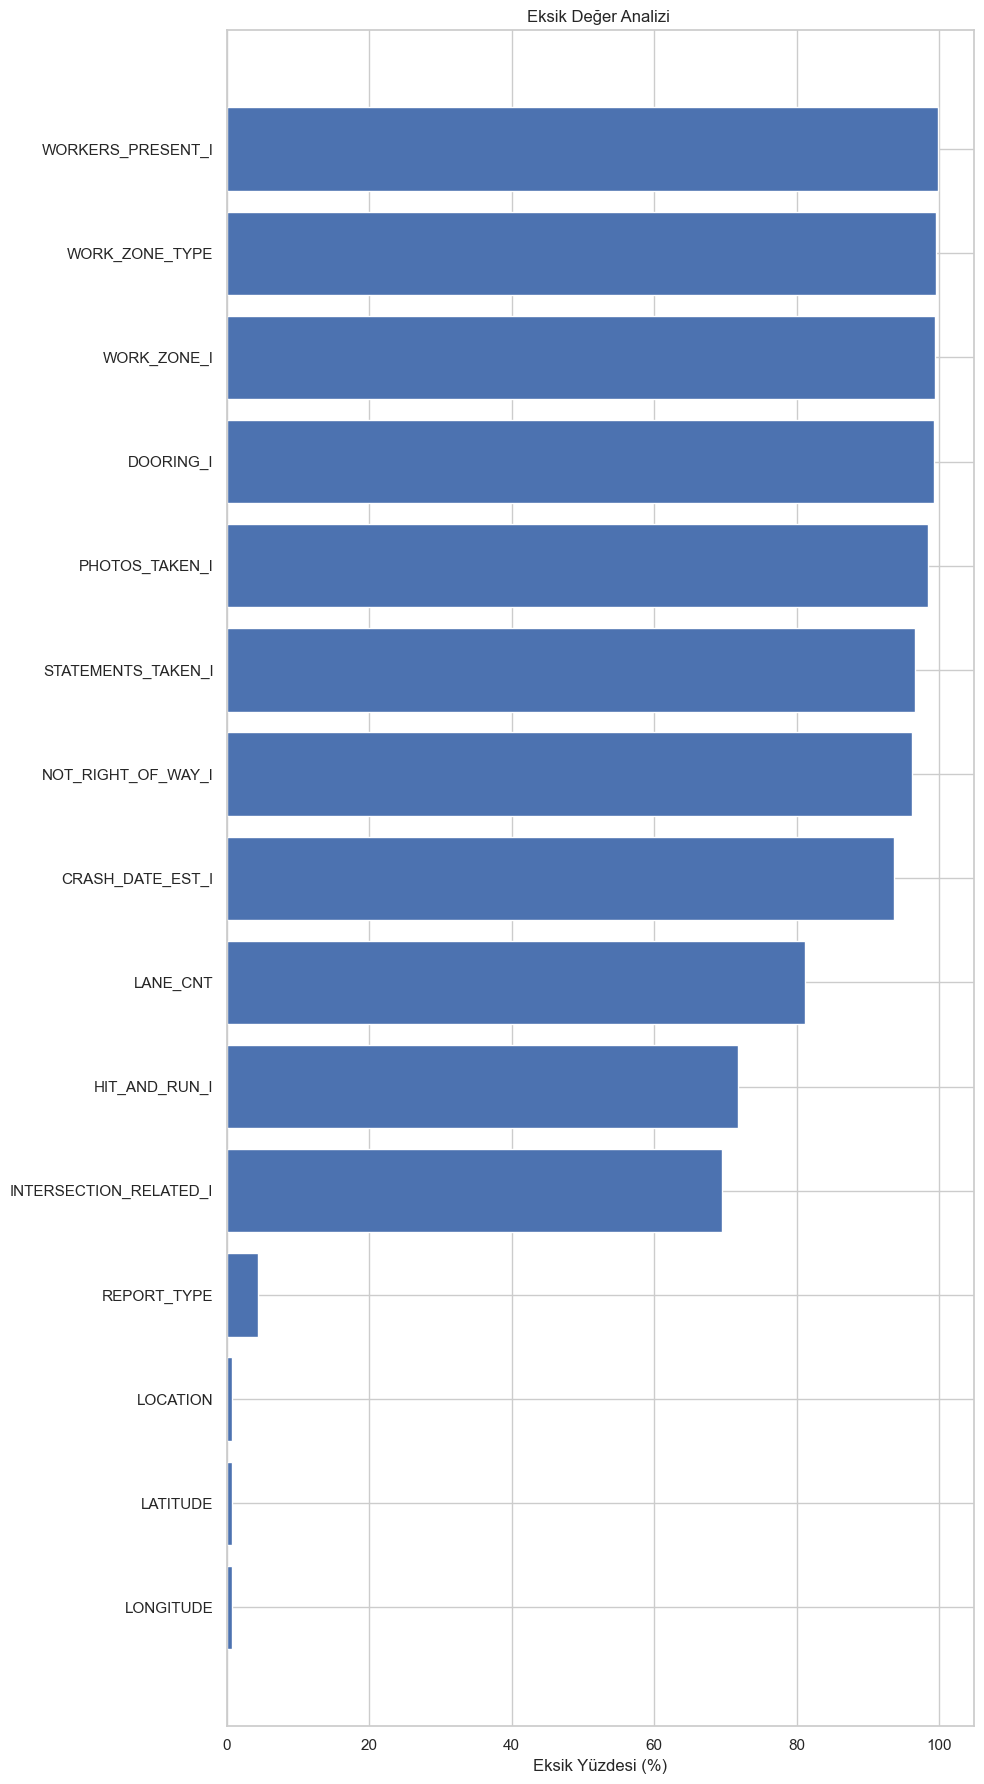

In [67]:
import matplotlib.pyplot as plt

# Eksik değer tablosu (senin kodun)
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

# --- GÖRSELLEŞTİRME ---
plt.figure(figsize=(10, 18))
plt.barh(eksik_df.head(15).index, eksik_df.head(15)['eksik_yuzdesi'])
plt.xlabel("Eksik Yüzdesi (%)")
plt.title("Eksik Değer Analizi ")
plt.gca().invert_yaxis()  # En yüksek değeri üstte göstermek için
plt.tight_layout()
plt.show()

In [68]:
df.nunique().sort_values(ascending=False).head(20)

CRASH_RECORD_ID                300000
DATE_POLICE_NOTIFIED           276900
CRASH_DATE                     262654
LOCATION                       146840
LATITUDE                       146835
LONGITUDE                      146833
STREET_NO                       10535
STREET_NAME                      1477
BEAT_OF_OCCURRENCE                276
INJURIES_NO_INDICATION             41
PRIM_CONTRIBUTORY_CAUSE            40
SEC_CONTRIBUTORY_CAUSE             40
POSTED_SPEED_LIMIT                 37
LANE_CNT                           27
CRASH_HOUR                         24
TRAFFICWAY_TYPE                    20
INJURIES_NON_INCAPACITATING        20
INJURIES_TOTAL                     20
TRAFFIC_CONTROL_DEVICE             19
FIRST_CRASH_TYPE                   18
dtype: int64

<h4 style="color: #000000; font-weight: bold;"> 4- Gereksiz Sütunların Silinmesi:</h4>
Bu sütunlar, çok fazla eksik değer içermeleri, modelleme sürecine anlamlı bir katkı sağlamamaları, bazıların coğrafi koordinatlardan oluşması ve analiz aşamasında gereksiz gürültü yaratma ihtimalleri nedeniyle veri setinden çıkarılır. Bu şekilde veri daha temiz, daha anlaşılır ve modelleme için daha uygun bir hale getirilmiş olur.

In [69]:
silinecek_sutunlar = [
    'WORKERS_PRESENT_I','DOORING_I','WORK_ZONE_TYPE','WORK_ZONE_I',
    'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','NOT_RIGHT_OF_WAY_I',
    'CRASH_DATE_EST_I','LANE_CNT','INTERSECTION_RELATED_I','HIT_AND_RUN_I',
    'LATITUDE','LONGITUDE','CRASH_RECORD_ID','CRASH_DATE','DATE_POLICE_NOTIFIED',
    'STREET_NO','STREET_DIRECTION','STREET_NAME','LOCATION','REPORT_TYPE', 'BEAT_OF_OCCURRENCE'
]

df.drop(columns=silinecek_sutunlar, inplace=True)
print("Veri boyutu:", df.shape)

Veri boyutu: (300000, 26)


<h4 style="color: #000000; font-weight: bold;"> 5-Yaralanma Sütunlarının Silinmesi (Data Leakage Önleme): </h4>
Bu aşamada, kazaların sonuçlarını doğrudan içeren yaralanma sütunları veri setinden çıkarılır. Çünkü bu bilgiler, tahmin etmeye çalıştığımız sonucun ta kendisidir. Eğer model bu sütunları görmeye devam ederse, tahmin sürecinde gerçek cevabı önceden öğrenmiş olur ve bu durum “veri sızıntısı” olarak adlandırılan hataya yol açar. Böyle bir durumda model gerçekte olduğundan çok daha başarılı görünür, ancak gerçek hayatta aynı performansı gösteremez. Bu nedenle yaralanma ile ilgili tüm sütunlar kaldırılarak, modelin yalnızca kazanın gerçekleştiği koşullara bakarak bağımsız bir şekilde tahmin yapması sağlanır. Bu işlem, modelin güvenilirliğini ve doğruluğunu artırmak için kritik bir adımdır.

In [70]:
# Yaralanma sütunlarını kaldırma (leakage engelleme)
leak_cols = [
    'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION','INJURIES_UNKNOWN'
]

df.drop(columns=[c for c in leak_cols if c in df.columns], inplace=True)
print("Veri boyutu:", df.shape)


Veri boyutu: (300000, 19)


<h4 style="color: #000000; font-weight: bold;"> 6- Hedef Değişkenin Belirlenmesi: </h4>
Bu aşamada, modelin tahmin etmeyi amaçlayacağı hedef değişken belirlenir. Projede amaç, bir trafik kazasında meydana gelen yaralanmanın şiddetini tahmin etmek olduğu için MOST_SEVERE_INJURY sütunu hedef olarak seçilir. Bu sütun, kazadaki yaralanmanın türünü içerir ve modelin öğrenmesi gereken temel bilgiyi temsil eder.

In [71]:
target = "MOST_SEVERE_INJURY"

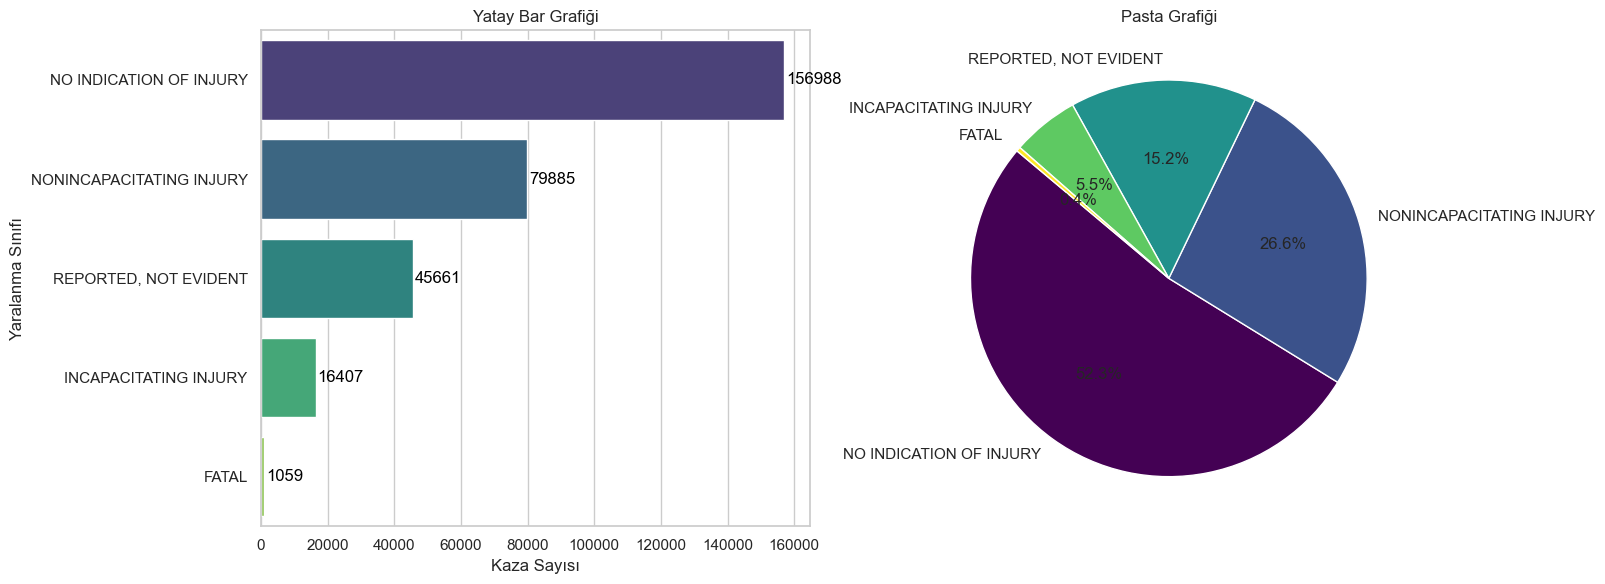

In [72]:
sayi = df[target].value_counts(dropna=False).sort_values(ascending=False)
etiketler = [str(i) if pd.notna(i) else 'NaN' for i in sayi.index]

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
barlar_yatay = sns.barplot(y=etiketler, x=sayi.values, palette="viridis")
for i, v in enumerate(sayi.values):
    barlar_yatay.text(v + 500, i, str(v), color='black', va='center')
plt.title("Yatay Bar Grafiği")
plt.xlabel("Kaza Sayısı")
plt.ylabel("Yaralanma Sınıfı")

plt.subplot(1, 2, 2)
plt.pie(sayi.values, labels=etiketler, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.viridis(np.linspace(0, 1, len(sayi))))
plt.title("Pasta Grafiği")
plt.tight_layout()
plt.show()

<h4 style="color: #000000; font-weight: bold;"> 7- Train/Test Ayırma: </h4>
Veri setinde yalnızca temel temizlik işlemleri yapıldıktan sonra, yani veriye herhangi bir öğrenme veya çıkarım sağlayacak işlem uygulanmadan önce train/test ayırma işlemi erken bir aşamada gerçekleştirilir. Bu şekilde veri sızıntısı engellenmiş olur. Böylece daha sonra yapılacak tüm işlemler yalnızca eğitim verisine dayanarak öğrenilir ve test verisi tamamen bağımsız kalır.

In [73]:
# === TARGET VE FEATURE AYIRMA ===
X = df.drop(columns=[target])
y = df[target]

# === 1) Önce Test Setini Ayır (TOPLAMIN %20'si)===
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# === 2) Train'den Validation Ayır (Train'in %5'i → toplamın yaklaşık %4'ü) ===
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.0625,  # 0.0625 = yüzde 5 yapmak için (0.05 / 0.80)
    random_state=42,
    stratify=y_train_full
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (225000, 18)
Validation: (15000, 18)
Test: (60000, 18)


<h4 style="color: #000000; font-weight: bold;"> 8- Keşifsel Veri Analizi (EDA) </h4>
Keşifsel Veri Analizi, veri setini daha yakından tanımamızı sağlayan önemli bir aşamadır. Bu bölümde amaç, verilerin içerdiği ilişki ve örüntüleri görselleştirmeler ve istatistiksel özetler üzerinden keşfetmektir. Hangi değişkenlerin hangi değerlerde yoğunlaştığını, uç değerlerin olup olmadığını, kategorik değişkenlerin dağılımını, sayısal değişkenlerin genel eğilimlerini ve hedef değişken ile diğer sütunlar arasındaki ilişkileri anlamaya çalışırız. Böylece veri setinin güçlü yönlerini, sorunlu alanlarını ve modelin öğrenmesi açısından potansiyel etkisi olan değişkenleri daha net görürüz.

<Figure size 2000x600 with 0 Axes>

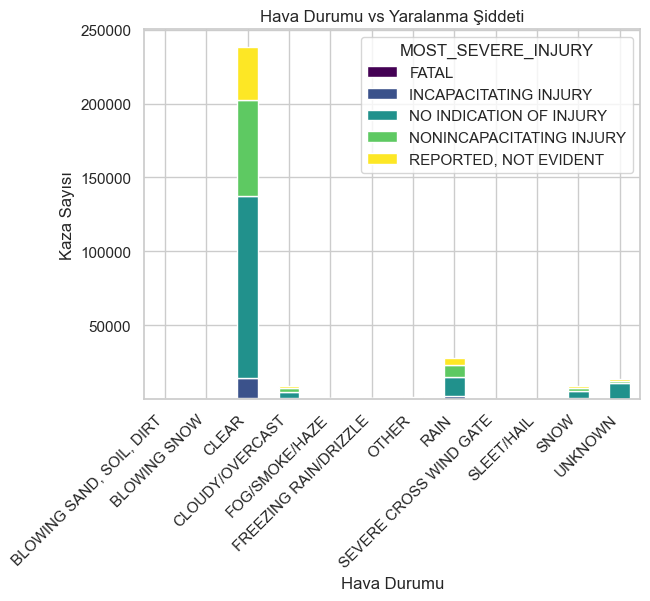

In [74]:
# WEATHER_CONDITION vs MOST_SEVERE_INJURY
plt.figure(figsize=(20,6))
cross = df.groupby(['WEATHER_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
cross.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Hava Durumu vs Yaralanma Şiddeti")
plt.xlabel("Hava Durumu")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45, ha='right')
plt.show()

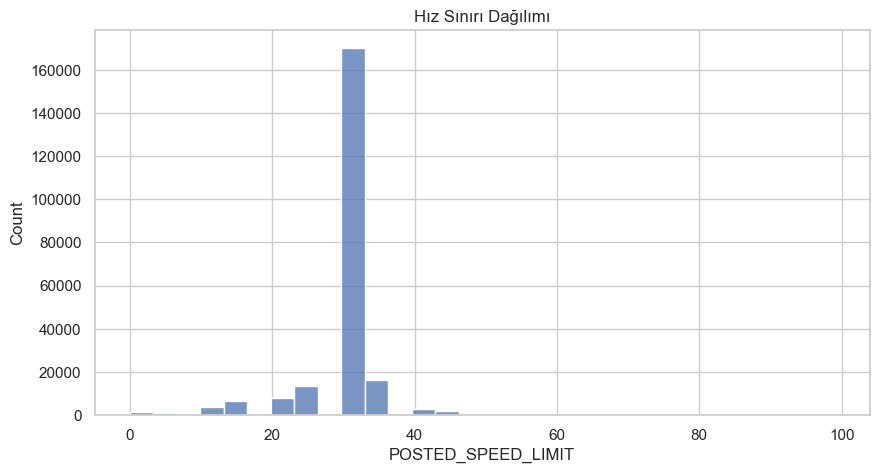

In [75]:
# Hız sınırı grafiği
plt.figure(figsize=(10,5))
sns.histplot(X_train['POSTED_SPEED_LIMIT'], bins=30)
plt.title("Hız Sınırı Dağılımı")
plt.show()

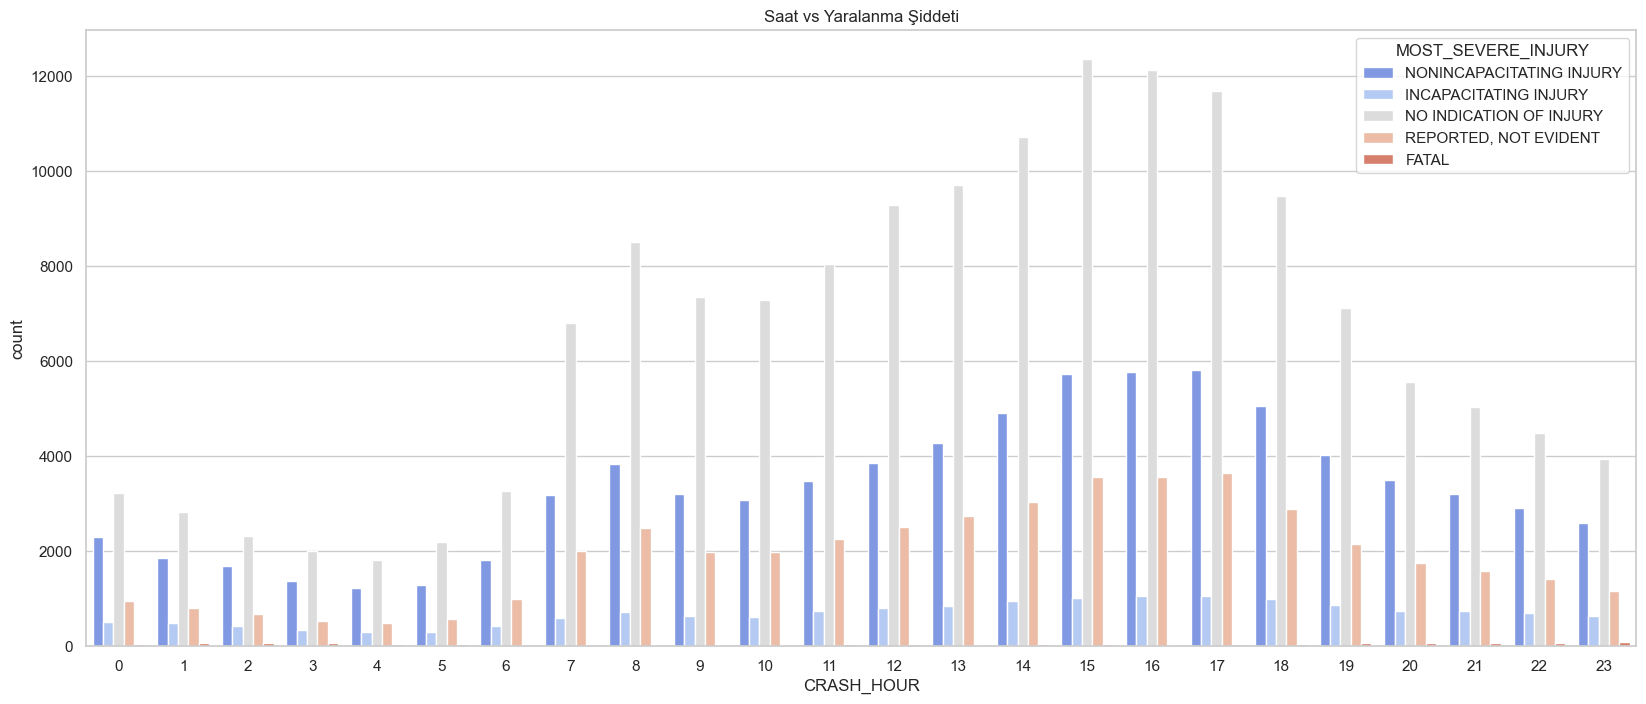

In [76]:
plt.figure(figsize=(20, 8))
sns.countplot(x='CRASH_HOUR', hue='MOST_SEVERE_INJURY', data=df, palette='coolwarm')
plt.title("Saat vs Yaralanma Şiddeti")
plt.show()


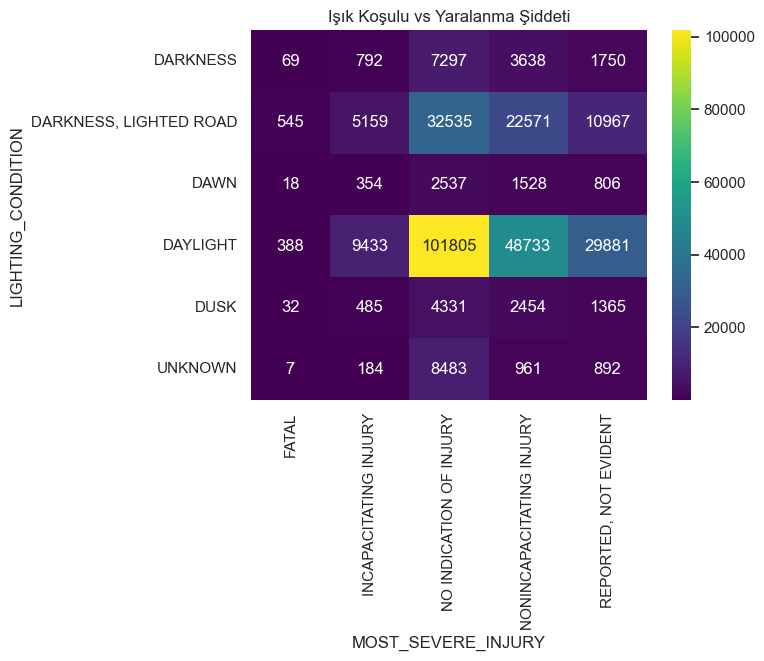

In [77]:
cross = df.groupby(['LIGHTING_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
sns.heatmap(cross, annot=True, fmt='d', cmap='viridis')
plt.title("Işık Koşulu vs Yaralanma Şiddeti")
plt.show()

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
# sayısal ve kategorik sütunları belirlenmesi
sayisal_sutunlar = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()
# Hedef değişken sayısal listeden çıkarılıyor
if 'MOST_SEVERE_INJURY' in sayisal_sutunlar:
    sayisal_sutunlar.remove('MOST_SEVERE_INJURY')
if 'MOST_SEVERE_INJURY' in kategorik_sutunlar:
    kategorik_sutunlar.remove('MOST_SEVERE_INJURY')

print("Sayısal sütun sayısı:", len(sayisal_sutunlar))
print("Kategorik sütun sayısı:", len(kategorik_sutunlar))


Sayısal sütun sayısı: 5
Kategorik sütun sayısı: 13


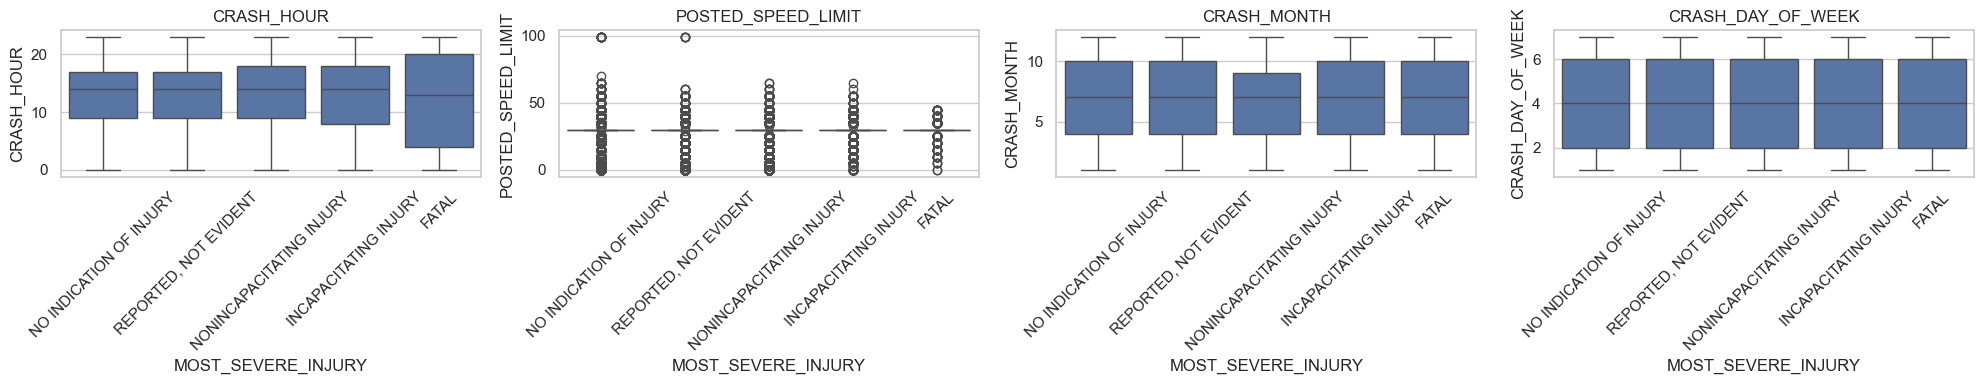

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_box_df = X_train.copy()
train_box_df["MOST_SEVERE_INJURY"] = y_train.values 

num_cols = train_box_df.select_dtypes(include=[np.number]).columns

var_series = train_box_df[num_cols].var().sort_values(ascending=False)
top_num_for_box = var_series.head(4).index

fig, axes = plt.subplots(1, len(top_num_for_box), figsize=(5 * len(top_num_for_box), 4))
if len(top_num_for_box) == 1:
    axes = [axes]

for ax, col in zip(axes, top_num_for_box):
    sns.boxplot(data=train_box_df, x="MOST_SEVERE_INJURY", y=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

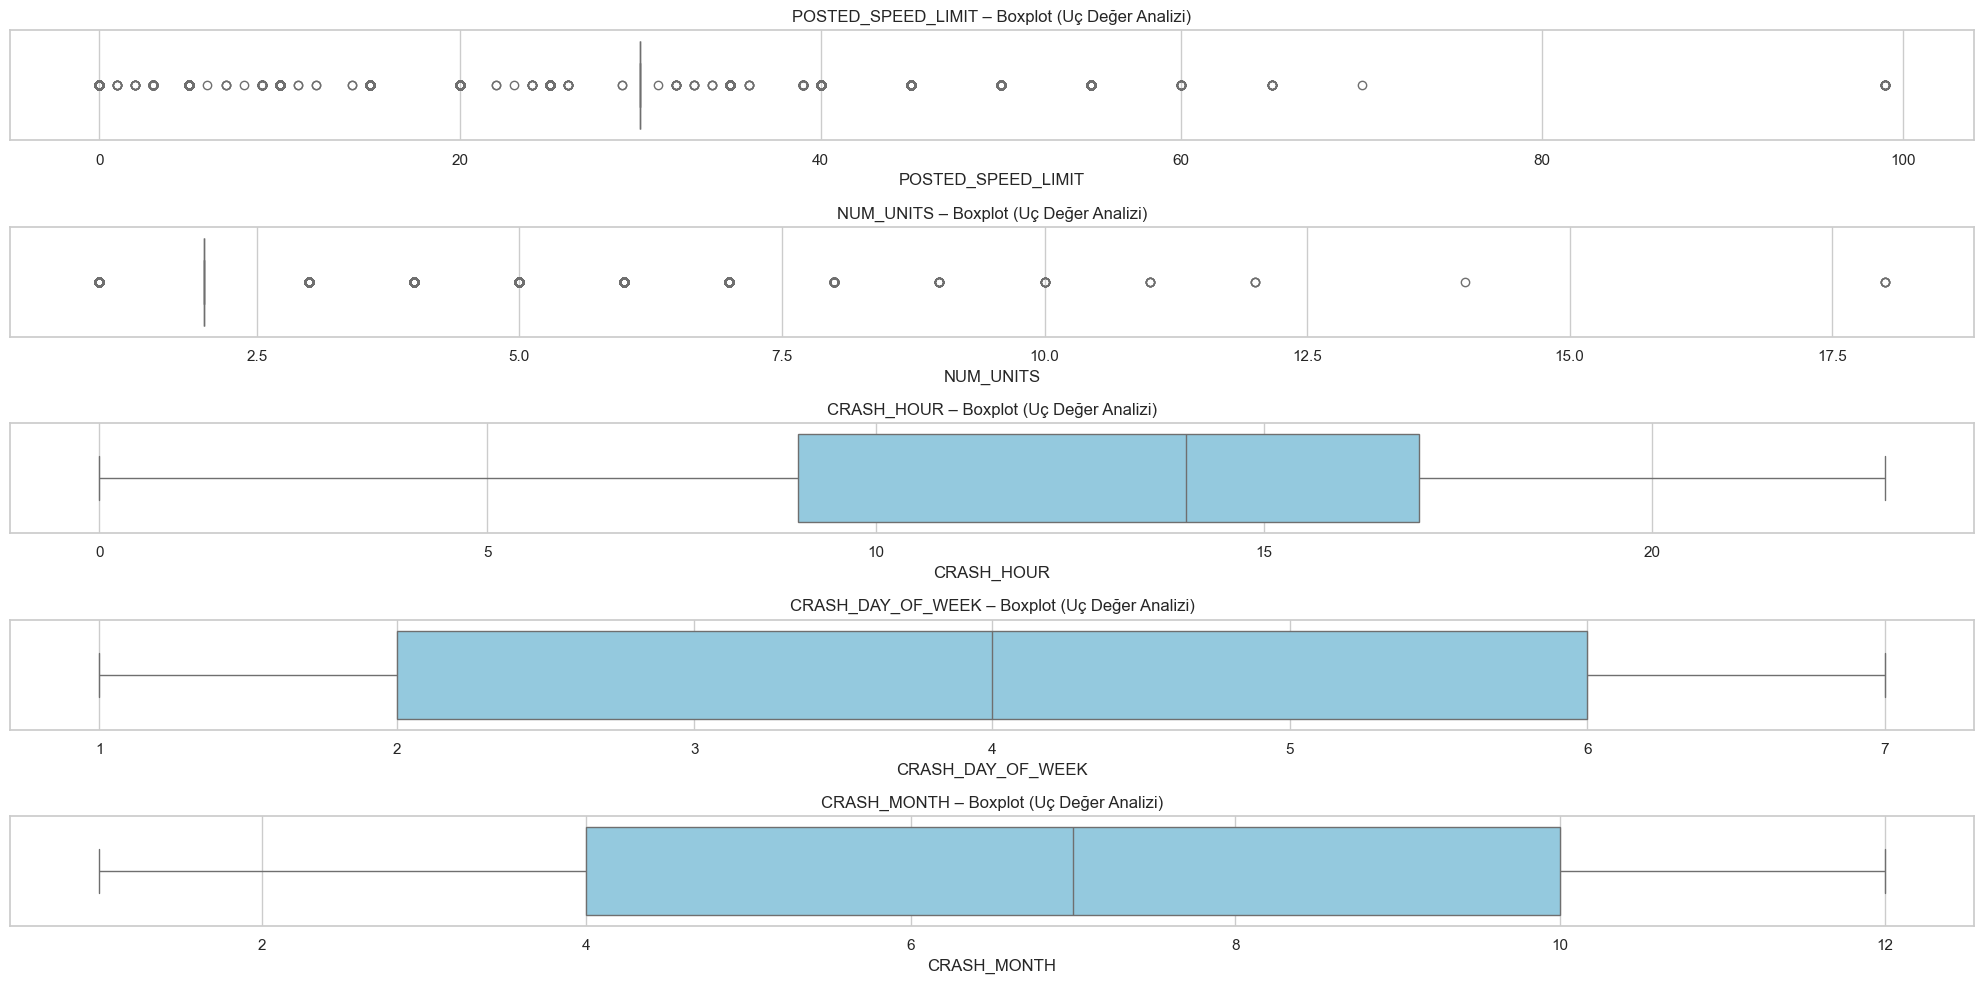

In [80]:
#SAYISAL SÜTUNLAR – UÇ DEĞER ANALİZİ
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} – Boxplot (Uç Değer Analizi)", fontsize=12)

plt.tight_layout()
plt.show()

In [81]:
# 5. Aykırı Değerleri Belirleme (Sadece bilgi amaçlı)
outlier_report = {}
num_cols = X_train.select_dtypes(include=[np.number]).columns
for c in num_cols:
    q1 = X_train[c].quantile(0.25)
    q3 = X_train[c].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_rate = ((X_train[c] < lower) | (X_train[c] > upper)).mean() * 100
    outlier_report[c] = round(outlier_rate, 2)

outlier_df = pd.DataFrame(list(outlier_report.items()), columns=["Sütun", "Aykırı Değer Oranı (%)"])
outlier_df = outlier_df.sort_values(by="Aykırı Değer Oranı (%)", ascending=False)

print("\nAykırı değer oranı en yüksek sütunlar:")
print(outlier_df.head(10))


Aykırı değer oranı en yüksek sütunlar:
                Sütun  Aykırı Değer Oranı (%)
0  POSTED_SPEED_LIMIT                   24.45
1           NUM_UNITS                   15.33
2          CRASH_HOUR                    0.00
3   CRASH_DAY_OF_WEEK                    0.00
4         CRASH_MONTH                    0.00


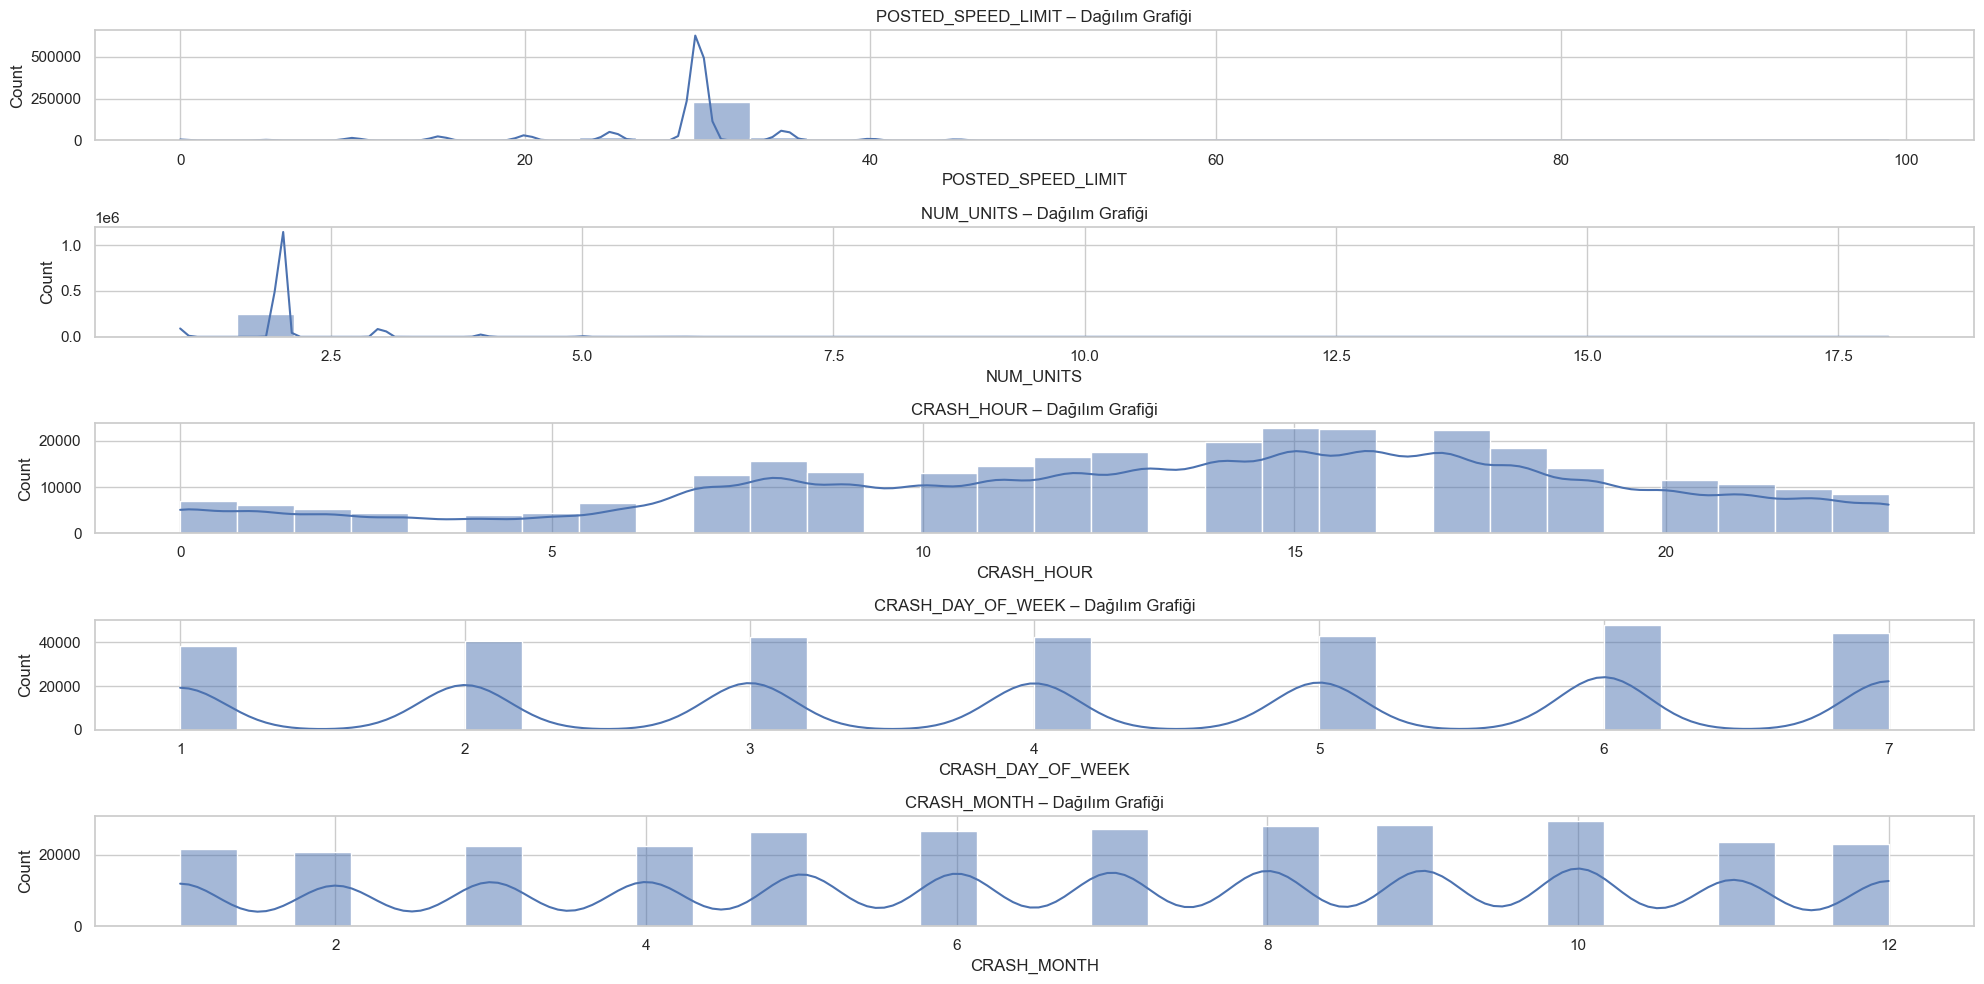

In [82]:
#SAYISAL DEĞİŞKENLERİN DAĞILIMI 
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} – Dağılım Grafiği", fontsize=12)

plt.tight_layout()
plt.show()

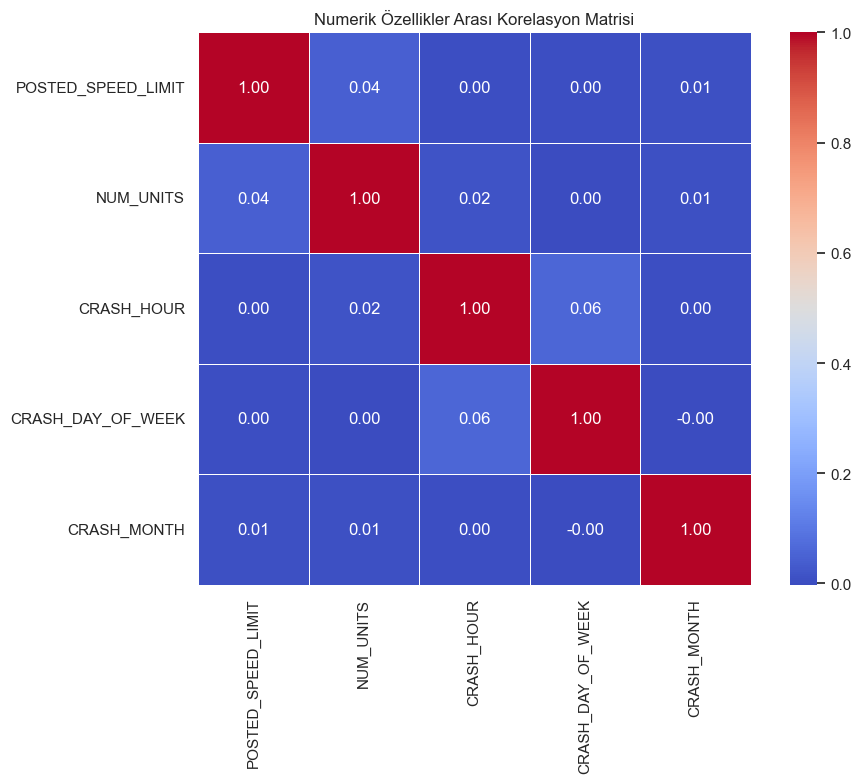

In [83]:
# =========================
# Amaç:
# - Numerik sütunların birbirleriyle olan ilişkisini (korelasyon) görmek
# - Çok güçlü ilişkili (yüksek korelasyonlu) değişkenleri tespit etmek
# - Gereksiz (birbirini tekrar eden) özellik olup olmadığını anlamak

# 1) Sadece numerik sütunları al
X_train_num_corr = X_train[sayisal_sutunlar].copy()

# 2) Korelasyon matrisi hesapla (varsayılan = Pearson)
corr_matrix = X_train_num_corr.corr()

# 3) Korelasyon matrisini görselleştir (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # Hücrelere korelasyon değerini yaz
    fmt=".2f",            # 2 basamak göster
    cmap="coolwarm",      # Renk paleti
    square=True,
    linewidths=0.5
)
plt.title("Numerik Özellikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()

In [84]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   POSTED_SPEED_LIMIT       300000 non-null  int64 
 1   TRAFFIC_CONTROL_DEVICE   300000 non-null  object
 2   DEVICE_CONDITION         300000 non-null  object
 3   WEATHER_CONDITION        300000 non-null  object
 4   LIGHTING_CONDITION       300000 non-null  object
 5   FIRST_CRASH_TYPE         300000 non-null  object
 6   TRAFFICWAY_TYPE          300000 non-null  object
 7   ALIGNMENT                300000 non-null  object
 8   ROADWAY_SURFACE_COND     300000 non-null  object
 9   ROAD_DEFECT              300000 non-null  object
 10  CRASH_TYPE               300000 non-null  object
 11  DAMAGE                   300000 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  300000 non-null  object
 13  SEC_CONTRIBUTORY_CAUSE   300000 non-null  object
 14  NUM_UNITS           

<h4 style="color: #000000; font-weight: bold;">9- FEATURE ENGİNNERİNG:</h4>

Bu projede uyguladığımız Feature Engineering adımları, ham trafik kazası verisini daha anlamlı ve modele daha açıklayıcı hâle getirmek için tasarlandı. Hız limitinin kategorilere ayrılması, kazanın gerçekleştiği saatin yoğunluk seviyesine göre sınıflandırılması, gece–gündüz flag’lerinin eklenmesi, hafta içi/hafta sonu ayrımı, mevsim bilgisi, hava durumu ile ışık koşullarının birleştirilmesi, yol tipine göre risk düzeyi atanması gibi yeni değişkenler; kazanın şiddetini etkileyen gizli ilişkileri ortaya çıkararak modelin öğrenmesini kolaylaştırır. Buna ek olarak, hız × birim sayısı veya hız × saat gibi etkileşim (interaction) özellikleri üretildi; böylece model, değişkenler arasındaki karmaşık bağlantıları daha iyi yakalayabilir. Signal olarak düşük etkili kategorilerin birleşmesi, binary risk göstergeleri (ör. ciddi hasar flag’i) gibi dönüşümler de veri setini daha temiz ve makine öğrenmesi algoritmalarının daha verimli öğrenebileceği bir forma soktu. Tüm bu Feature Engineering adımları, trafik kazası şiddeti tahmininde modelin ayırt edici gücünü artırmak ve dengesiz veri yapısına rağmen daha doğru sınıflandırma yapabilmesini sağlamak amacıyla uygulanmıştır.

In [85]:
def feature_engineering(df):
    df = df.copy()
    
    # Hız Sınırı
    df['SPEED_CAT'] = pd.cut(
        df['POSTED_SPEED_LIMIT'],
        bins=[0, 25, 45, 90],
        labels=['LOW', 'MEDIUM', 'HIGH']
    )

    # Saat Yoğunluk Grubu
    def hour_group(h):
        if 0 <= h <= 5:
            return "GECE"
        elif 6 <= h <= 9:
            return "SABAH_YOGUN"
        elif 10 <= h <= 15:
            return "GUNDUZ"
        elif 16 <= h <= 19:
            return "AKSAM_YOGUN"
        else:
            return "GECE_GEC"

    df['CRASH_HOUR_GROUP'] = df['CRASH_HOUR'].apply(hour_group)

    # Gece / Gündüz flag
    df["IS_NIGHT"] = df['CRASH_HOUR'].apply(lambda x: 1 if (x <= 5 or x >= 21) else 0)

    # Hafta içi / Hafta sonu
    df["IS_WEEKEND"] = df['CRASH_DAY_OF_WEEK'].apply(lambda x: 1 if x in [6,7] else 0)

    # Ay mevsim grubu
    def season(m):
        if m in [12,1,2]:
            return "WINTER"
        elif m in [3,4,5]:
            return "SPRING"
        elif m in [6,7,8]:
            return "SUMMER"
        else:
            return "FALL"

    df["CRASH_SEASON"] = df["CRASH_MONTH"].apply(season)

    # Hava + Işık Kombinasyonu
    df['WEATHER_LIGHT_RISK'] = (
        df['WEATHER_CONDITION'] + "_" + df['LIGHTING_CONDITION']
        )

    # Yol tipi risk grupları (genişletilmiş)
    road_risk_map = {
        # HIGH RISK
        "T-INTERSECTION": "HIGH_RISK",
        "Y-INTERSECTION": "HIGH_RISK",
        "L-INTERSECTION": "HIGH_RISK",
        "FOUR WAY": "HIGH_RISK",
        "FIVE POINT, OR MORE": "HIGH_RISK",
        "ROUNDABOUT": "HIGH_RISK",
    
        # MEDIUM RISK
        "DIVIDED - W/MEDIAN (NOT RAISED)": "MEDIUM_RISK",
        "DIVIDED - W/MEDIAN BARRIER": "MEDIUM_RISK",
        "ONE-WAY": "MEDIUM_RISK",
        "TRAFFIC ROUTE": "MEDIUM_RISK",
        "RAMP": "MEDIUM_RISK",
    
        # LOW RISK
        "ALLEY": "LOW_RISK",
        "PARKING LOT": "LOW_RISK",
        "DRIVEWAY": "LOW_RISK",
    
        # NORMAL
        "NOT DIVIDED": "NORMAL_RISK",
        "CENTER TURN LANE": "NORMAL_RISK",
        "OTHER": "NORMAL_RISK",
    
        # UNKNOWN
        "NOT REPORTED": "UNKNOWN",
        "UNKNOWN": "UNKNOWN",
        "UNKNOWN INTERSECTION TYPE": "UNKNOWN"
    }
    
    df["ROAD_RISK"] = df["TRAFFICWAY_TYPE"].map(road_risk_map).fillna("NORMAL_RISK")


   # DAMAGE Çok Kategorili (0-1-2)
    df["DAMAGE_CAT"] = df["DAMAGE"].map({
        "$500 OR LESS": 0,
        "$501 - $1,500": 1,
        "OVER $1,500": 2
    })

    # Hız sınırı × Yol tipi etkileşim özelliği
    df["SPEED_X_UNITS"] = df["POSTED_SPEED_LIMIT"] * df["NUM_UNITS"]

    # Hız sınırı × Saat
    df["SPEED_X_HOUR"] = df["POSTED_SPEED_LIMIT"] * df["CRASH_HOUR"]

    return df


In [86]:
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

In [87]:
sayisal_sutunlar = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
kategorik_sutunlar = X_train.select_dtypes(include=['object']).columns.tolist()

# Hedef sütunu listelerden çıkar
if target in sayisal_sutunlar:
    sayisal_sutunlar.remove(target)
if target in kategorik_sutunlar:
    kategorik_sutunlar.remove(target)

print("Sayısal:", len(sayisal_sutunlar))
print("Kategorik:", len(kategorik_sutunlar))

Sayısal: 10
Kategorik: 17


<h4 style="color: #000000; font-weight: bold;">10- BASE MODEL:</h4>
Bu aşamada, modelleme sürecinin başlangıç performansını değerlendirebilmek amacıyla herhangi bir feature selection (özellik seçimi) veya dimension reduction (boyut indirgeme) uygulanmamıştır. Tüm orijinal ve üretilmiş (feature engineering) değişkenler, olduğu gibi modele verilmiştir.

In [88]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [89]:
# Preprocessor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), sayisal_sutunlar),
        ("cat", OneHotEncoder(handle_unknown="ignore"), kategorik_sutunlar)
    ]
)

In [90]:
# Preprocessor sonrası oluşan toplam özellik sayısını görmek için
preprocessor.fit(X_train)
len(preprocessor.get_feature_names_out())


281

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, f1_score

# --- ORTAK PREPROCESSING YAPISI ---
# (Hafızada varsa tekrar çalıştırmana gerek yok ama garanti olsun diye ekliyorum)

sayisal_sutunlar = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True)) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, sayisal_sutunlar),
        ('cat', categorical_transformer, kategorik_sutunlar)
    ],
    verbose_feature_names_out=False
)

In [92]:
print("--- 1. SENARYO: BASE MODEL (DECISION TREE) EĞİTİMİ ---")

pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'  # Sınıf dengesizliği için kritik ayar
    ))
])

pipeline_base.fit(X_train, y_train)
y_pred_base = pipeline_base.predict(X_test)

print("\n--- BASE MODEL SONUÇLARI ---")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("Weighted F1 Score:", f1_score(y_test, y_pred_base, average='weighted'))
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred_base))

--- 1. SENARYO: BASE MODEL (DECISION TREE) EĞİTİMİ ---

--- BASE MODEL SONUÇLARI ---
Accuracy: 0.6525166666666666
Weighted F1 Score: 0.6560141485926545

Sınıflandırma Raporu:

                          precision    recall  f1-score   support

                   FATAL       0.02      0.02      0.02       212
   INCAPACITATING INJURY       0.13      0.14      0.13      3281
 NO INDICATION OF INJURY       0.90      0.88      0.89     31398
NONINCAPACITATING INJURY       0.50      0.50      0.50     15977
   REPORTED, NOT EVIDENT       0.32      0.33      0.32      9132

                accuracy                           0.65     60000
               macro avg       0.37      0.37      0.37     60000
            weighted avg       0.66      0.65      0.66     60000



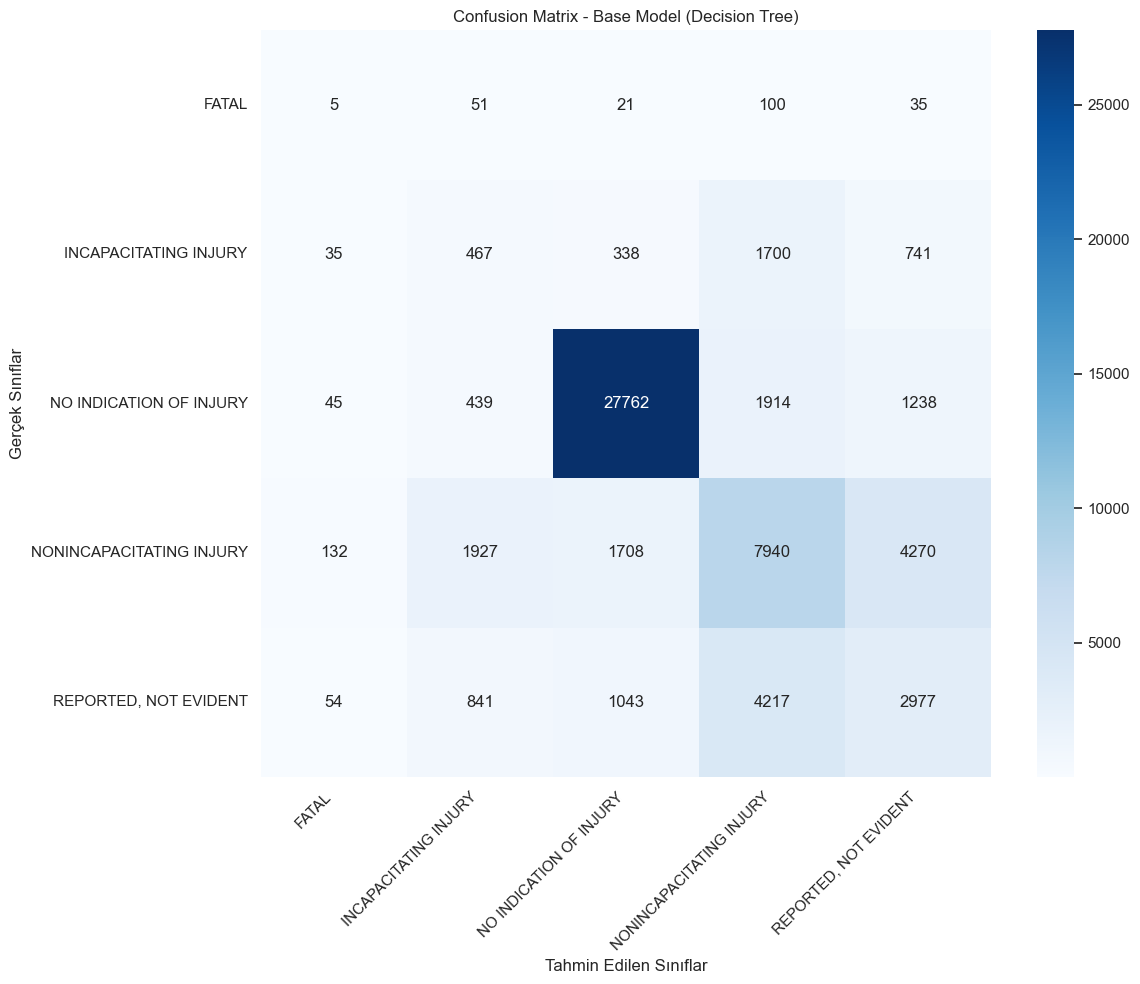

In [93]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matrisi Hesapla
cm = confusion_matrix(y_test, y_pred_base)

# 2. Görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=pipeline_base.classes_, 
            yticklabels=pipeline_base.classes_)

plt.title("Confusion Matrix - Base Model (Decision Tree)")
plt.ylabel("Gerçek Sınıflar")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.xticks(rotation=45, ha='right') # Etiketleri okumak için çevir
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h4 style="color: #000000; font-weight: bold;">11- Feature Selection (Mutual Information) + Base Model:</h4>
Bu aşamada modelin performansını artırmak için Mutual Information (MI) tabanlı bir Feature Selection yöntemi uygulanmıştır. Mutual Information, her bir özelliğin hedef değişkenle paylaştığı bilgi miktarını ölçer. Bu yöntem, özellikle kategorik + sayısal değişkenlerin karışık olduğu veri setlerinde en doğru seçimdir. Kullandığımız değişkenler de bu şekilde olduğu için bu feature selection yöntemi seçilmiştir.

In [94]:
print("--- 2. SENARYO: FEATURE SELECTION (MI) + DECISION TREE ---")

pipeline_fs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Mutual Information ile en iyi 50 özelliği seç
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=50)), 
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

# Bu işlem veri boyutuna göre 1-2 dakika sürebilir
pipeline_fs.fit(X_train, y_train)
y_pred_fs = pipeline_fs.predict(X_test)

print("\n--- FEATURE SELECTION MODEL SONUÇLARI --0-")
print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("Weighted F1 Score:", f1_score(y_test, y_pred_fs, average='weighted'))
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred_fs))

--- 2. SENARYO: FEATURE SELECTION (MI) + DECISION TREE ---

--- FEATURE SELECTION MODEL SONUÇLARI --0-
Accuracy: 0.6371
Weighted F1 Score: 0.6585648224563913

Sınıflandırma Raporu:

                          precision    recall  f1-score   support

                   FATAL       0.02      0.08      0.03       212
   INCAPACITATING INJURY       0.12      0.23      0.16      3281
 NO INDICATION OF INJURY       0.95      0.87      0.91     31398
NONINCAPACITATING INJURY       0.50      0.39      0.44     15977
   REPORTED, NOT EVIDENT       0.35      0.42      0.38      9132

                accuracy                           0.64     60000
               macro avg       0.39      0.40      0.38     60000
            weighted avg       0.69      0.64      0.66     60000



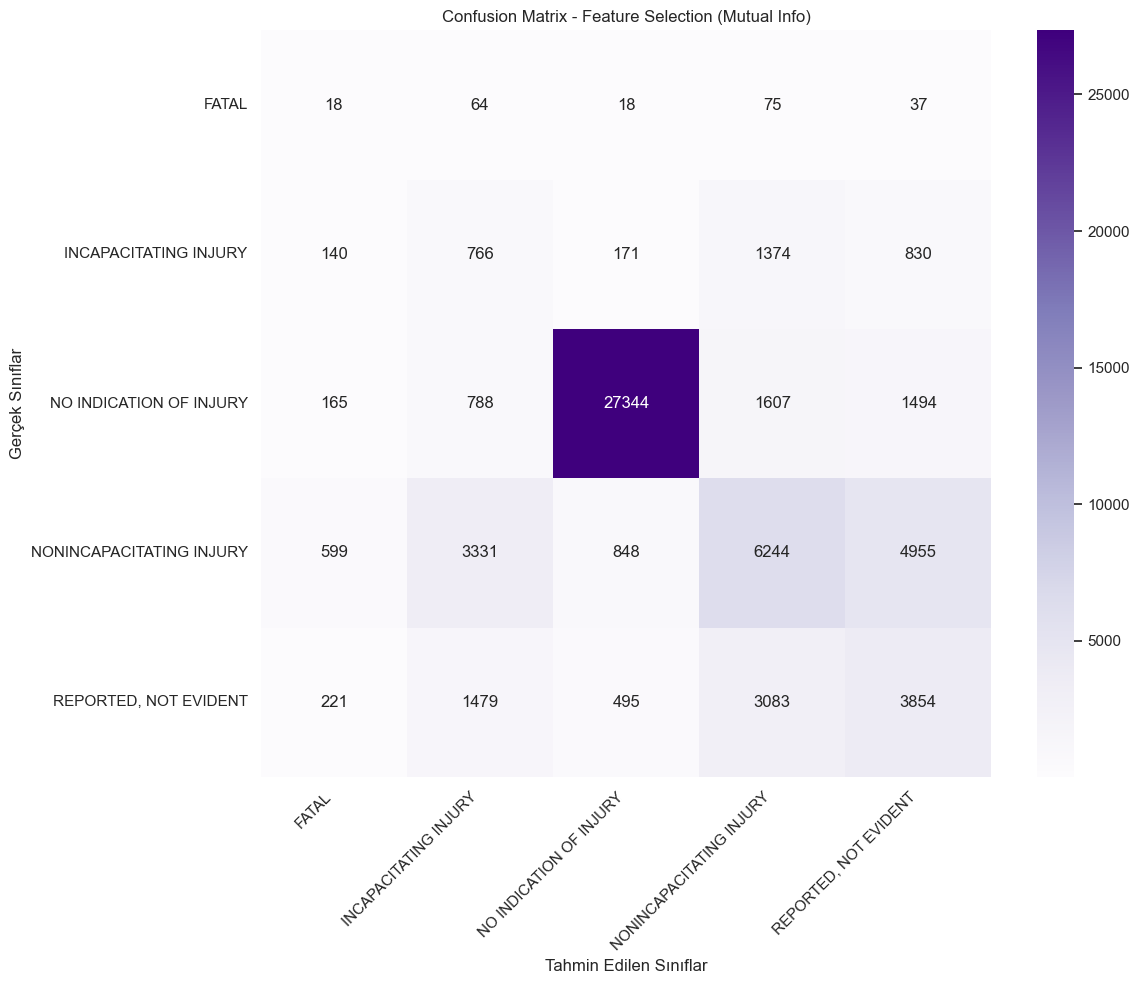

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matrisi Hesapla (y_pred_fs kullandığımıza dikkat)
cm = confusion_matrix(y_test, y_pred_fs)

# 2. Görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", # Farklı renk olsun karışmasın
            xticklabels=pipeline_fs.classes_, 
            yticklabels=pipeline_fs.classes_)

plt.title("Confusion Matrix - Feature Selection (Mutual Info)")
plt.ylabel("Gerçek Sınıflar")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h4 style="color: #000000; font-weight: bold;">12- Dimension Reduction (PCA) + Base Model</h4>
Bu aşamada modelin performansını ve hesaplama verimliliğini artırmak amacıyla boyut indirgeme (Dimension Reduction) tekniği olan Principal Component Analysis (PCA) uygulanmıştır. PCA, orijinal özellikleri doğrusal bileşimler şeklinde yeniden oluşturarak daha düşük boyutlu yeni bileşenler üretir. Bu yöntem, özellikle çok sayıda ve birbiriyle yüksek korelasyonlu değişkenler olduğunda bilgi tekrarını azaltır ve daha sade bir veri temsili sağlar.

In [96]:
print("--- 3. SENARYO: DIMENSION REDUCTION (SVD) + DECISION TREE ---")

pipeline_dr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Veriyi 50 bileşene sıkıştır
    ('dim_reduction', TruncatedSVD(n_components=50, random_state=42)),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

pipeline_dr.fit(X_train, y_train)
y_pred_dr = pipeline_dr.predict(X_test)

print("\n--- DIMENSION REDUCTION MODEL SONUÇLARI ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dr))
print("Weighted F1 Score:", f1_score(y_test, y_pred_dr, average='weighted'))
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred_dr))

--- 3. SENARYO: DIMENSION REDUCTION (SVD) + DECISION TREE ---

--- DIMENSION REDUCTION MODEL SONUÇLARI ---
Accuracy: 0.6358
Weighted F1 Score: 0.6377240420234596

Sınıflandırma Raporu:

                          precision    recall  f1-score   support

                   FATAL       0.02      0.03      0.02       212
   INCAPACITATING INJURY       0.11      0.12      0.11      3281
 NO INDICATION OF INJURY       0.87      0.87      0.87     31398
NONINCAPACITATING INJURY       0.49      0.48      0.48     15977
   REPORTED, NOT EVIDENT       0.32      0.32      0.32      9132

                accuracy                           0.64     60000
               macro avg       0.36      0.36      0.36     60000
            weighted avg       0.64      0.64      0.64     60000



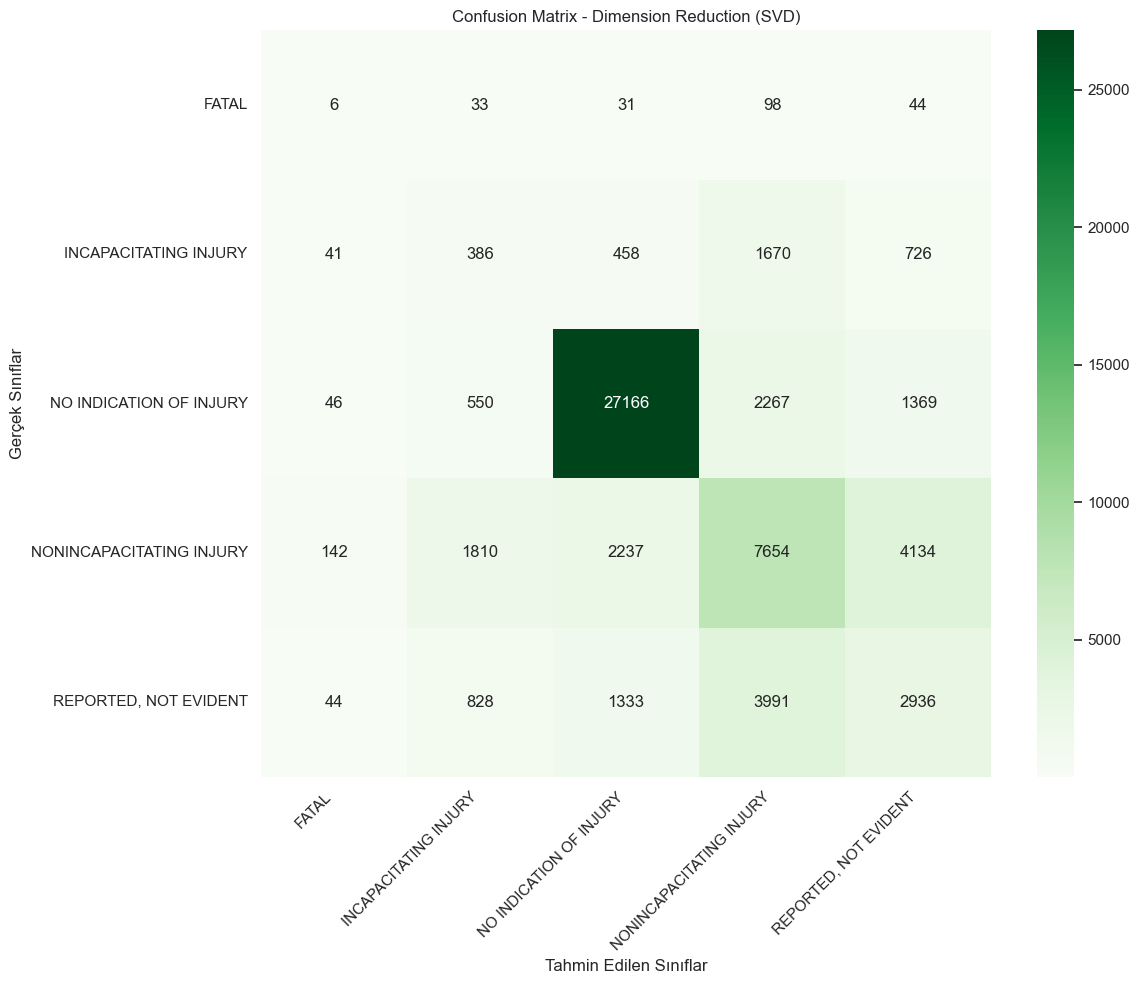

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matrisi Hesapla (y_pred_dr kullandığımıza dikkat)
cm = confusion_matrix(y_test, y_pred_dr)

# 2. Görselleştir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", # Farklı renk (Yeşil Tonları)
            xticklabels=pipeline_dr.classes_, 
            yticklabels=pipeline_dr.classes_)

plt.title("Confusion Matrix - Dimension Reduction (SVD)")
plt.ylabel("Gerçek Sınıflar")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--- Hafıza Taranıyor ---
✅ BULUNDU: 'Base Model' için 'y_pred_base' değişkeni kullanıldı.
✅ BULUNDU: 'Feature Selection' için 'y_pred_fs' değişkeni kullanıldı.
✅ BULUNDU: 'PCA / Dim. Red.' için 'y_pred_dr' değişkeni kullanıldı.

   SONUÇ TABLOSU


,Stage,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,Base Model,DecisionTree,0.652517,0.373602,0.374615,0.372964
1,Feature Selection,DecisionTree,0.637100,0.382338,0.400420,0.386226
2,PCA / Dim. Red.,DecisionTree,0.635800,0.361568,0.362347,0.361097


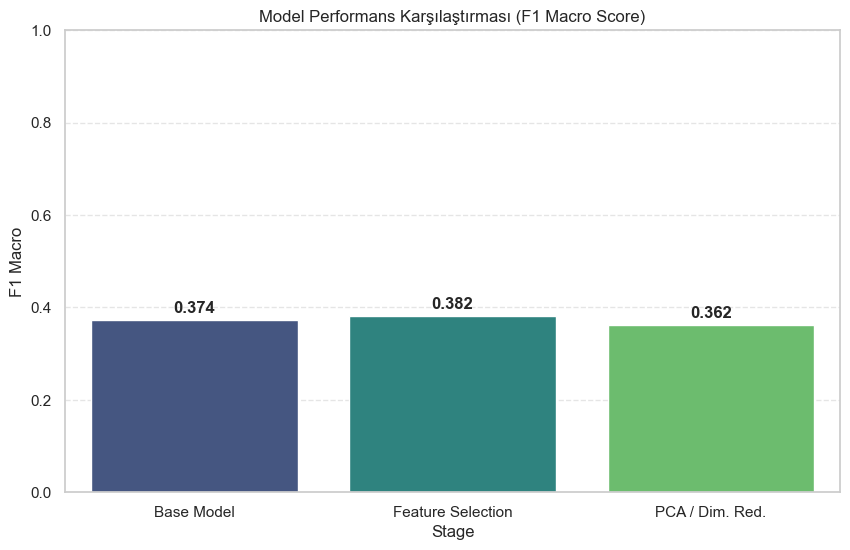

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Sonuç listesini sıfırla
results_list = []
bulunanlar = []

# --- AKILLI DEĞİŞKEN ARAMA FONKSİYONU ---
def veriyi_bul_ve_ekle(stage_name, possible_names, y_true):
    for var_name in possible_names:
        if var_name in globals(): # Global hafızada bu isimde bir değişken var mı?
            y_pred = globals()[var_name]
            
            # Puanları Hesapla
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='macro')
            recall = recall_score(y_true, y_pred, average='macro')
            precision = precision_score(y_true, y_pred, average='macro')
            
            results_list.append({
                'Stage': stage_name,
                'Model': 'DecisionTree',
                'Accuracy': acc,
                'F1 Macro': f1,
                'Recall Macro': recall,
                'Precision Macro': precision
            })
            bulunanlar.append(stage_name)
            print(f"✅ BULUNDU: '{stage_name}' için '{var_name}' değişkeni kullanıldı.")
            return # Bulunca döngüden çık
    print(f"❌ BULUNAMADI: '{stage_name}' için veri hafızada yok.")

# --- ARAMA BAŞLIYOR ---
print("--- Hafıza Taranıyor ---")

# 1. Base Model için olası isimler
veriyi_bul_ve_ekle("Base Model", 
                   ['y_pred_base_smote', 'y_pred_base', 'y_pred'], 
                   y_test)

# 2. Feature Selection için olası isimler
veriyi_bul_ve_ekle("Feature Selection", 
                   ['y_pred_fs_smote', 'y_pred_fs', 'y_pred_tuned'], 
                   y_test)

# 3. PCA için olası isimler
veriyi_bul_ve_ekle("PCA / Dim. Red.", 
                   ['y_pred_dr_smote', 'y_pred_dr', 'y_pred_pca'], 
                   y_test)

# --- TABLO VE GRAFİK ---
if len(results_list) > 0:
    results_df = pd.DataFrame(results_list)
    
    print("\n" + "="*40)
    print("   SONUÇ TABLOSU")
    print("="*40)
    try:
        display(results_df)
    except:
        print(results_df.to_string(index=False))

    # Grafik
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Stage', y='F1 Macro', data=results_df, palette='viridis')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontweight='bold')
    
    plt.title("Model Performans Karşılaştırması (F1 Macro Score)")
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("\n⚠️ KRİTİK HATA: Hafıza tamamen boş görünüyor.")
    print("Bunun sebebi 'Kernel Restart' yapmış olmanız olabilir.")
    print("Çözüm: Yukarıdaki 3 eğitim kod bloğunu (fit yapanları) tekrar çalıştırıp hemen ardından buraya gelmelisiniz.")

<h4 style="color: #000000; font-weight: bold;">13-GELİŞMİŞ ENSEMBLE MODELLER</h4>
Bu aşamada, trafik kazalarındaki yaralanma şiddetinin daha doğru tahmin edilebilmesi amacıyla gelişmiş ensemble öğrenme yöntemleri kullanılmıştır. Veri setinin yüksek boyutlu yapısı, sınıflar arasındaki dengesizlik ve değişkenler arasındaki karmaşık ilişkiler nedeniyle, tekil modellere kıyasla daha güçlü genelleme yeteneği sunan yaklaşımlar tercih edilmiştir.
Bu kapsamda, gradyan artırma tabanlı LightGBM, örnek ağırlıklandırma prensibine dayanan AdaBoost ve farklı öğrenicilerin çıktılarının birleştirildiği Stacking Ensemble modelleri uygulanmıştır. Modellerin performansını artırmak amacıyla kritik hiperparametreler, ilgili model için en uygun hiperparametre optimizasyon yöntemi kullanılarak ayarlanmıştır
Elde edilen sonuçlar, ensemble tabanlı yaklaşımların temel karar ağacı modellerine kıyasla daha dengeli ve yüksek tahmin performansı sunduğunu göstermektedir.

<h5 style="color: #000000; font-weight: bold; padding-left: 40px;">1. LightGBM (Optuna ile Hiperparametre Optimizasyonu)
</h5>
Bu modelde, gradyan artırma tabanlı LightGBM algoritması kullanılmış ve model performansını maksimize etmek amacıyla hiperparametre optimizasyonu Optuna kütüphanesi ile gerçekleştirilmiştir. Optuna, akıllı arama stratejisi sayesinde parametre uzayında daha hızlı ve etkili bir keşif yaparak, sınıflar arası dengesizliğe sahip veri setlerinde daha dengeli ve yüksek performanslı modeller elde edilmesini sağlamaktadır.

In [99]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [100]:
import optuna
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import numpy as np

def lgbm_objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 900),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'max_depth': trial.suggest_int('max_depth', -1, 25),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            objective='multiclass',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            **params
        ))
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1
    )

    return scores.mean()


In [101]:
study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective, n_trials=10)

print("En iyi F1 Macro:", study.best_value)
print("En iyi parametreler:")
print(study.best_params)


[I 2025-12-21 17:39:58,634] A new study created in memory with name: no-name-3cabe791-8e69-4e7d-95d5-2ada80350b2e
[I 2025-12-21 17:42:49,085] Trial 0 finished with value: 0.41627229261190024 and parameters: {'n_estimators': 525, 'learning_rate': 0.07382898805115307, 'num_leaves': 74, 'max_depth': 0, 'subsample': 0.8269442215562605, 'colsample_bytree': 0.9170718415821372}. Best is trial 0 with value: 0.41627229261190024.
[I 2025-12-21 17:46:19,396] Trial 1 finished with value: 0.4008156622286543 and parameters: {'n_estimators': 767, 'learning_rate': 0.01451790974915499, 'num_leaves': 214, 'max_depth': 7, 'subsample': 0.7914461940410062, 'colsample_bytree': 0.7207494212154082}. Best is trial 0 with value: 0.41627229261190024.
[I 2025-12-21 17:49:15,663] Trial 2 finished with value: 0.4120132158095924 and parameters: {'n_estimators': 339, 'learning_rate': 0.014498273919024524, 'num_leaves': 191, 'max_depth': 12, 'subsample': 0.6588574741999729, 'colsample_bytree': 0.7021662395184605}. Bes

En iyi F1 Macro: 0.42120764181649717
En iyi parametreler:
{'n_estimators': 631, 'learning_rate': 0.021318564612801676, 'num_leaves': 195, 'max_depth': 16, 'subsample': 0.8733973836809128, 'colsample_bytree': 0.6985177098316148}


In [102]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    results = {
        'Model': model_name,
        'Accuracy': acc,
        'F1 Macro': f1,
        'Recall Macro': recall,
        'Precision Macro': precision
    }

    return results


In [103]:
best_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        objective='multiclass',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        **study.best_params
    ))
])

best_lgbm.fit(X_train, y_train)

res_lgbm = evaluate_model(
    "LightGBM (Optuna Manual)",
    best_lgbm,
    X_test,
    y_test
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 225000, number of used features: 260
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[


--- Classification Report | LightGBM (Optuna Manual) ---

                          precision    recall  f1-score   support

                   FATAL       0.03      0.17      0.06       212
   INCAPACITATING INJURY       0.16      0.28      0.20      3281
 NO INDICATION OF INJURY       0.99      0.86      0.92     31398
NONINCAPACITATING INJURY       0.53      0.38      0.44     15977
   REPORTED, NOT EVIDENT       0.38      0.59      0.46      9132

                accuracy                           0.66     60000
               macro avg       0.42      0.46      0.42     60000
            weighted avg       0.73      0.66      0.68     60000



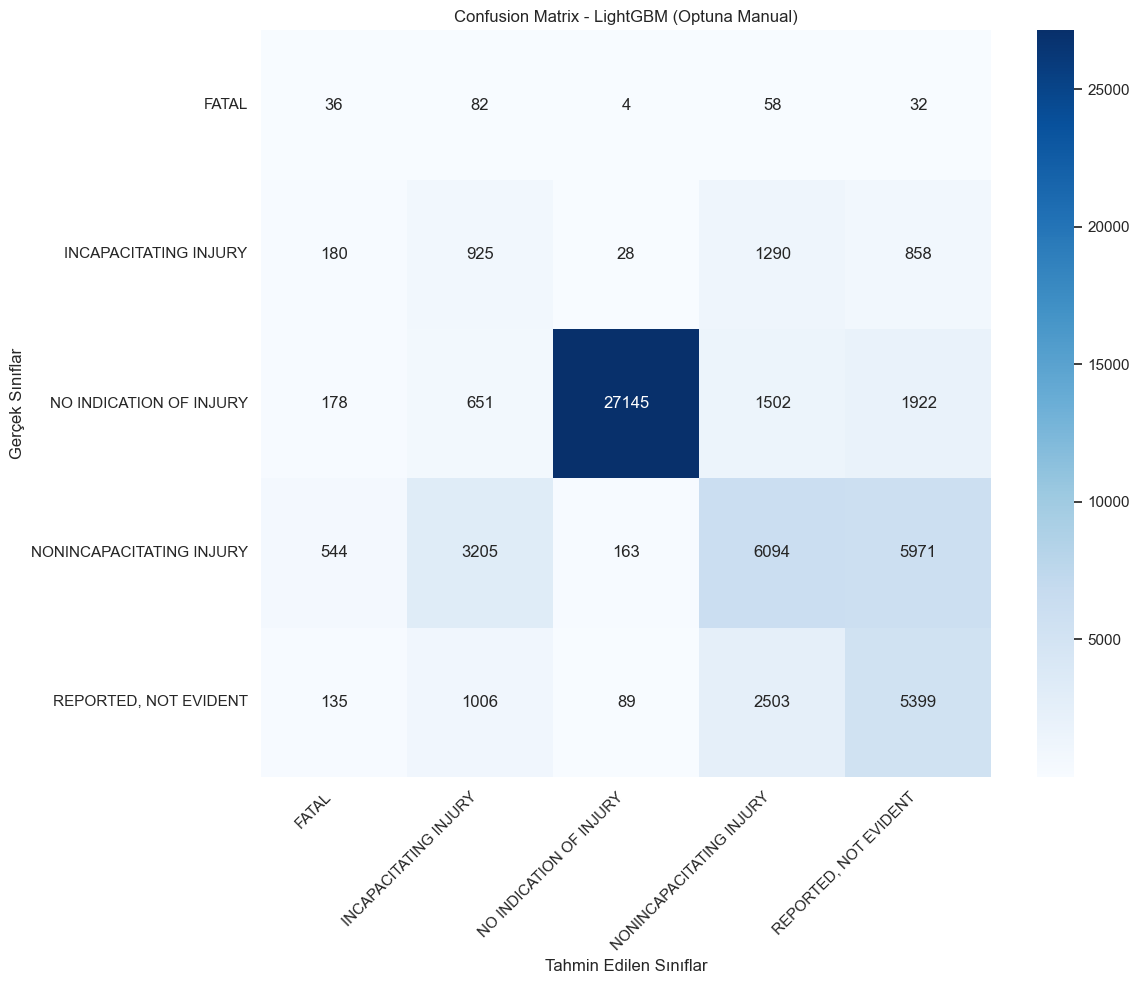

In [104]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Test tahminleri
y_pred_lgbm = best_lgbm.predict(X_test)

# === CLASSIFICATION REPORT ===
print("\n--- Classification Report | LightGBM (Optuna Manual) ---\n")
print(classification_report(y_test, y_pred_lgbm))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_lgbm.classes_,
    yticklabels=best_lgbm.classes_
)

plt.title("Confusion Matrix - LightGBM (Optuna Manual)")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [105]:
import pandas as pd

# Sadece LightGBM için tablo
lgbm_results_df = pd.DataFrame([{
    "Model": "LightGBM (Optuna Manual)",
    "Accuracy": res_lgbm["Accuracy"],
    "F1 Macro": res_lgbm["F1 Macro"],
    "Recall Macro": res_lgbm["Recall Macro"],
    "Precision Macro": res_lgbm["Precision Macro"]
}])

lgbm_results_df


,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,LightGBM (Optuna Manual),0.659983,0.417735,0.457785,0.418773


<h5 style="color: #000000; font-weight: bold; padding-left: 40px;">
2. AdaBoost (GridSearchCV ile Hiperparametre Optimizasyonu)
</h5>
Bu modelde, ardışık öğrenme prensibine dayanan AdaBoost algoritması kullanılmış ve modelin hiperparametreleri GridSearchCV yöntemi ile optimize edilmiştir. GridSearchCV, belirlenen parametre kombinasyonlarını sistematik olarak değerlendirerek, sınıflar arası dengesizliğin bulunduğu veri setlerinde makro performans metriklerini iyileştirmeyi amaçlamaktadır.


In [106]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

ada_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=2,
            class_weight='balanced',
            random_state=42
        ),
        random_state=42
    ))
])


In [107]:
ada_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1]
}


In [108]:
ada_search = GridSearchCV(
    estimator=ada_pipe,
    param_grid=ada_params,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

ada_search.fit(X_train, y_train)

best_ada = ada_search.best_estimator_

print("En iyi parametreler:", ada_search.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
En iyi parametreler: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}


In [109]:
res_ada = evaluate_model(
    "AdaBoost (GridSearch)",
    best_ada,
    X_test,
    y_test
)



--- Classification Report | AdaBoost ---

                          precision    recall  f1-score   support

                   FATAL       0.01      0.55      0.03       212
   INCAPACITATING INJURY       0.18      0.19      0.18      3281
 NO INDICATION OF INJURY       1.00      0.85      0.92     31398
NONINCAPACITATING INJURY       0.48      0.47      0.48     15977
   REPORTED, NOT EVIDENT       0.45      0.31      0.37      9132

                accuracy                           0.63     60000
               macro avg       0.42      0.47      0.40     60000
            weighted avg       0.73      0.63      0.67     60000



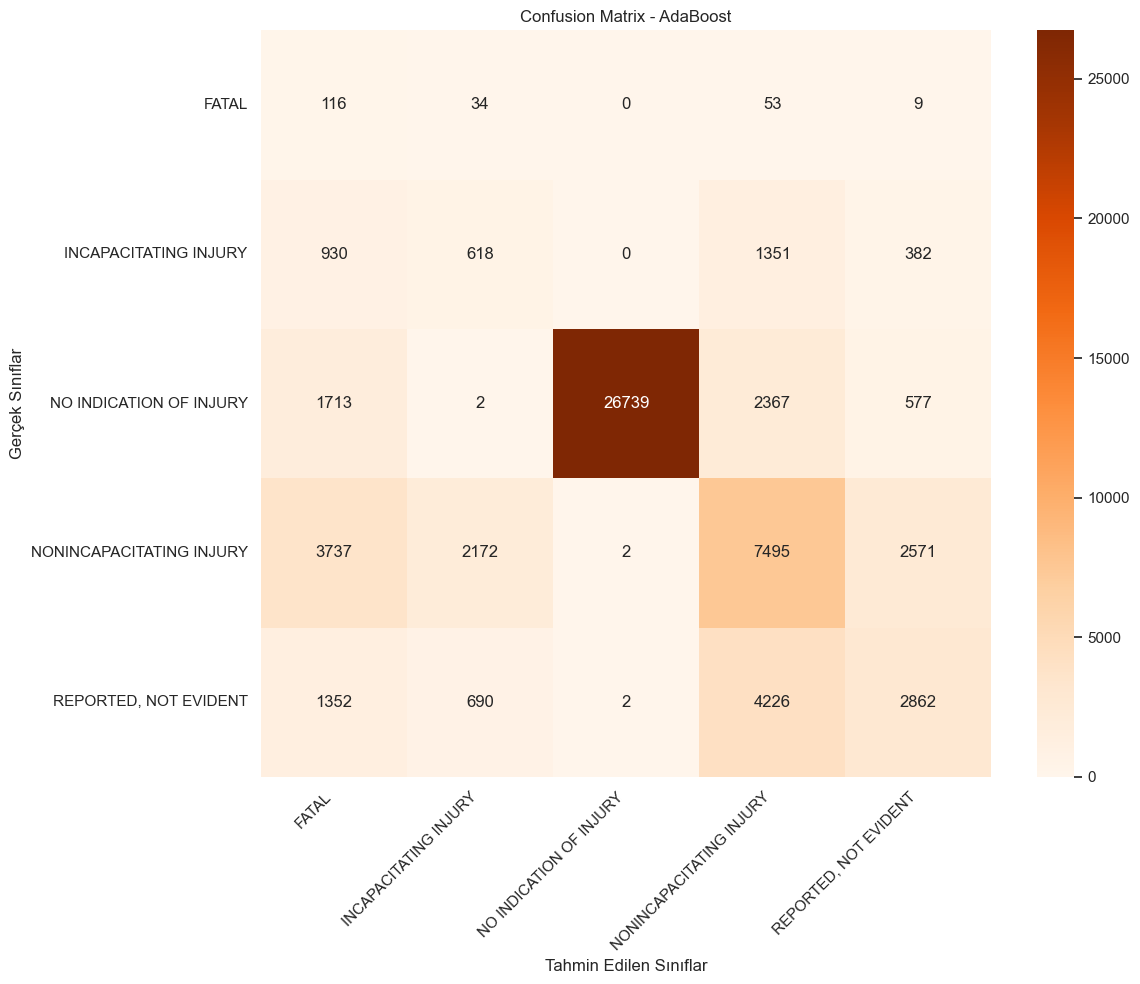

In [110]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_ada = best_ada.predict(X_test)

print("\n--- Classification Report | AdaBoost ---\n")
print(classification_report(y_test, y_pred_ada))

cm = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=best_ada.classes_,
    yticklabels=best_ada.classes_
)
plt.title("Confusion Matrix - AdaBoost")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [111]:
import pandas as pd

# LightGBM + AdaBoost sonuçları
ensemble_results_df = pd.DataFrame([
    {
        "Model": "LightGBM (Optuna Manual)",
        "Accuracy": res_lgbm["Accuracy"],
        "F1 Macro": res_lgbm["F1 Macro"],
        "Recall Macro": res_lgbm["Recall Macro"],
        "Precision Macro": res_lgbm["Precision Macro"]
    },
    {
        "Model": "AdaBoost (GridSearch)",
        "Accuracy": res_ada["Accuracy"],
        "F1 Macro": res_ada["F1 Macro"],
        "Recall Macro": res_ada["Recall Macro"],
        "Precision Macro": res_ada["Precision Macro"]
    }
])

ensemble_results_df


,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,LightGBM (Optuna Manual),0.659983,0.417735,0.457785,0.418773
1,AdaBoost (GridSearch),0.630500,0.395055,0.473931,0.424263


<h5 style="color: #000000; font-weight: bold; padding-left: 40px;">3. Stacking Ensemble Model</h5>
Bu modelde, farklı öğrenme algoritmalarının güçlü yönlerinden faydalanmak amacıyla Stacking Ensemble yaklaşımı kullanılmıştır. Birden fazla taban modelin tahminleri birleştirilerek, üst düzey bir meta model aracılığıyla nihai tahminler elde edilmiştir. Bu yöntem, karmaşık veri yapılarında genelleme performansını artırarak daha dengeli ve güçlü sonuçlar üretmektedir.

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced'
        )),
        ('lr', LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ))
    ],
    final_estimator=LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ),
    cv=3,
    n_jobs=-1
)


In [118]:
from imblearn.pipeline import Pipeline

stacking_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', stacking_clf)
])


In [119]:
stacking_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH', 'IS_NIGHT',
                                                   'IS_WEEKEND', 'DAMAGE_CAT',
                                                   'SPEED_X_UNITS',
                                                   'SPEED_X_HOUR']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_v...
                                                   'CRASH_SEASON',
                                                   'WEATHER_LIGHT_RISK',
                                                   'ROAD_RISK'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 StackingClassifier(cv=3,
                                    estimators=[('dt',
                                                 DecisionTreeClassifier(class_weight='balanced',
                                                                        random_state=42)),
                                                ('lr',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=1000))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000),
                                    n_jobs=-1))])

In [120]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_stack = stacking_pipe.predict(X_test)

print("\n--- Classification Report | Stacking Ensemble ---\n")
print(classification_report(y_test, y_pred_stack))



--- Classification Report | Stacking Ensemble ---

                          precision    recall  f1-score   support

                   FATAL       0.02      0.64      0.04       212
   INCAPACITATING INJURY       0.12      0.19      0.15      3281
 NO INDICATION OF INJURY       0.99      0.86      0.92     31398
NONINCAPACITATING INJURY       0.54      0.23      0.32     15977
   REPORTED, NOT EVIDENT       0.39      0.59      0.47      9132

                accuracy                           0.61     60000
               macro avg       0.41      0.50      0.38     60000
            weighted avg       0.73      0.61      0.65     60000



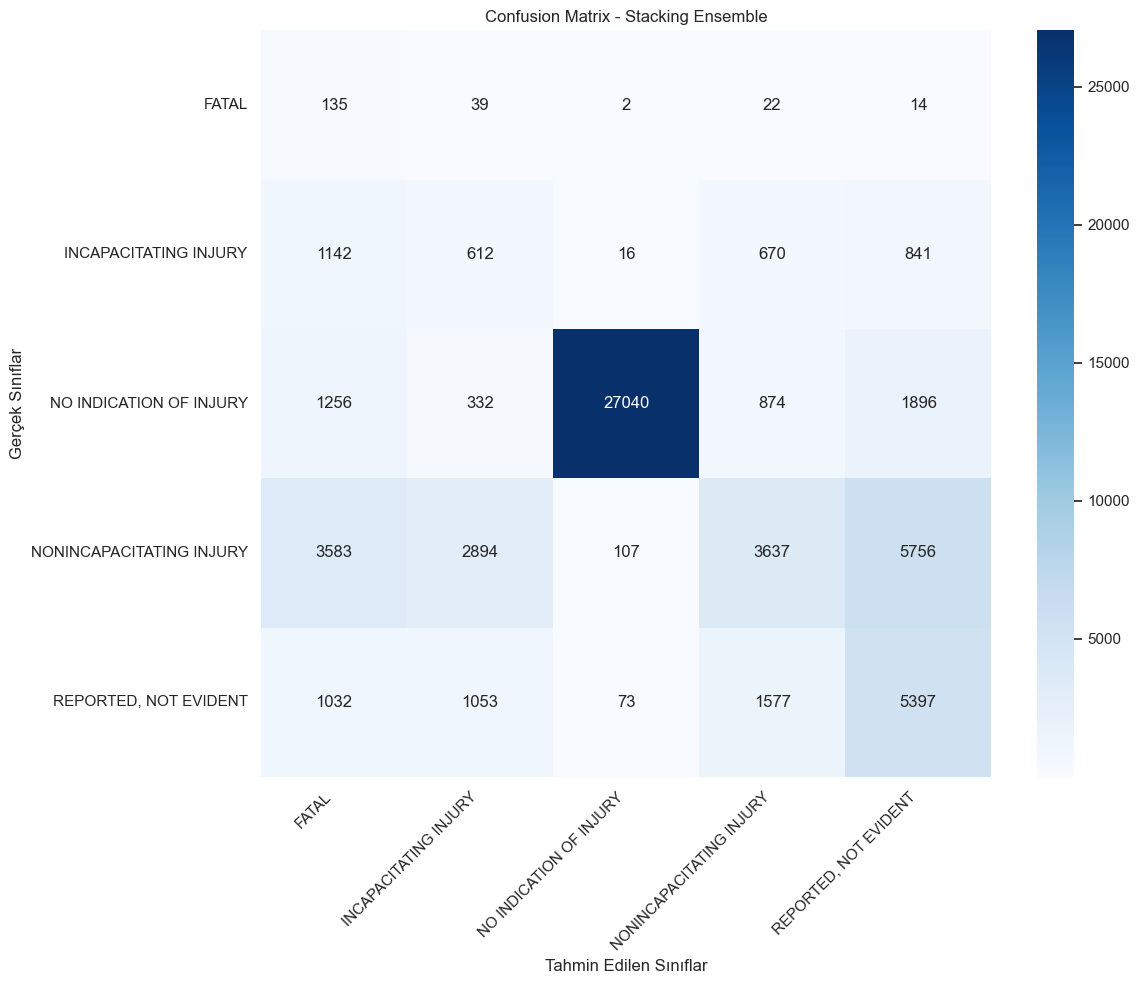

In [121]:
cm = confusion_matrix(y_test, y_pred_stack)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=stacking_pipe.classes_,
    yticklabels=stacking_pipe.classes_
)
plt.title("Confusion Matrix - Stacking Ensemble")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [122]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

res_stack = {
    "Model": "Stacking Ensemble",
    "Accuracy": accuracy_score(y_test, y_pred_stack),
    "F1 Macro": f1_score(y_test, y_pred_stack, average='macro'),
    "Recall Macro": recall_score(y_test, y_pred_stack, average='macro'),
    "Precision Macro": precision_score(y_test, y_pred_stack, average='macro')
}

In [123]:
final_results_df = pd.DataFrame([
    {
        "Model": "LightGBM (Optuna Manual)",
        **res_lgbm
    },
    {
        "Model": "AdaBoost (GridSearch)",
        **res_ada
    },
    res_stack
])

final_results_df

,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,LightGBM (Optuna Manual),0.659983,0.417735,0.457785,0.418773
1,AdaBoost (GridSearch),0.630500,0.395055,0.473931,0.424263
2,Stacking Ensemble,0.613683,0.379252,0.500632,0.412069


<h5 style="color: #000000; font-weight: bold; padding-left: 40px;">4. Gradient Boosting Model</h5>
Bu modelde, ardışık ağaç yapıları üzerinden hata odaklı öğrenme yaklaşımını benimseyen Gradient Boosting algoritması kullanılmıştır. Model, her bir iterasyonda önceki modellerin yaptığı hatalara daha fazla ağırlık vererek öğrenme sürecini iyileştirmekte ve böylece karmaşık ve doğrusal olmayan ilişkileri daha etkili biçimde yakalayabilmektedir. Bu yaklaşım, özellikle sınıflar arası ayrımın zor olduğu veri setlerinde tahmin performansını artırmaktadır.


In [137]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline


In [138]:
gb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])


In [139]:
gb_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH', 'IS_NIGHT',
                                                   'IS_WEEKEND', 'DAMAGE_CAT',
                                                   'SPEED_X_UNITS',
                                                   'SPEED_X_HOUR']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_v...
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE',
                                                   'SPEED_CAT',
                                                   'CRASH_HOUR_GROUP',
                                                   'CRASH_SEASON',
                                                   'WEATHER_LIGHT_RISK',
                                                   'ROAD_RISK'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 GradientBoostingClassifier(n_estimators=200,
                                            random_state=42))])

In [140]:
y_pred_gb = gb_pipe.predict(X_test)


In [141]:
from sklearn.metrics import classification_report

print("\n--- Classification Report | Gradient Boosting ---\n")
print(classification_report(y_test, y_pred_gb))



--- Classification Report | Gradient Boosting ---

                          precision    recall  f1-score   support

                   FATAL       0.15      0.03      0.05       212
   INCAPACITATING INJURY       0.32      0.00      0.00      3281
 NO INDICATION OF INJURY       0.96      0.88      0.92     31398
NONINCAPACITATING INJURY       0.51      0.86      0.64     15977
   REPORTED, NOT EVIDENT       0.50      0.24      0.32      9132

                accuracy                           0.73     60000
               macro avg       0.49      0.40      0.39     60000
            weighted avg       0.73      0.73      0.70     60000



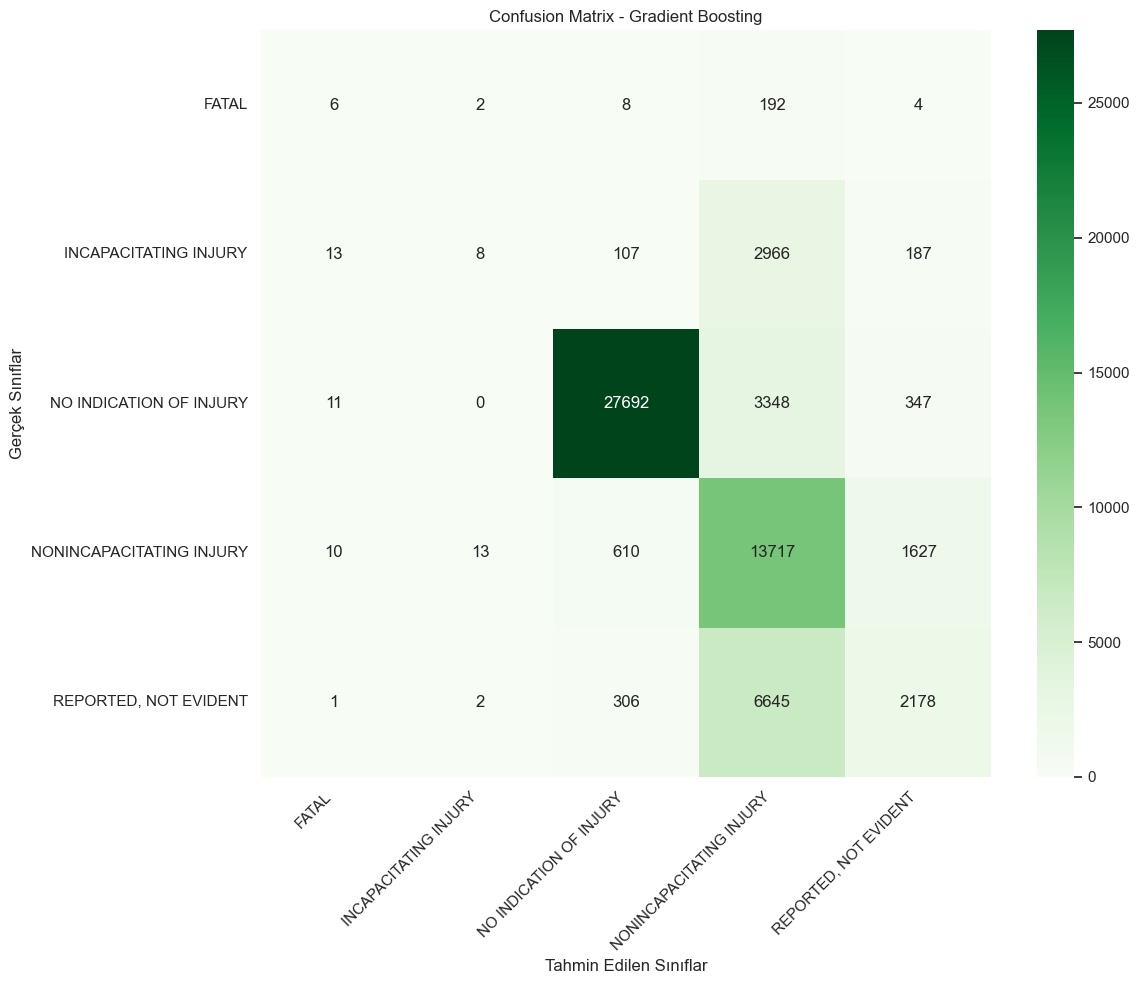

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=gb_pipe.classes_,
    yticklabels=gb_pipe.classes_
)
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Gerçek Sınıflar")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [143]:
gb_results = []

gb_results.append({
    'Stage': 'Ensemble Model',
    'Model': 'GradientBoosting',
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'F1 Macro': f1_score(y_test, y_pred_gb, average='macro'),
    'Recall Macro': recall_score(y_test, y_pred_gb, average='macro'),
    'Precision Macro': precision_score(y_test, y_pred_gb, average='macro')
})


In [144]:
gb_results_df = pd.DataFrame(gb_results)

print("\n" + "="*45)
print("   GRADIENT BOOSTING SONUÇ TABLOSU")
print("="*45)

try:
    display(gb_results_df)
except:
    print(gb_results_df.to_string(index=False))



   GRADIENT BOOSTING SONUÇ TABLOSU


,Stage,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,Ensemble Model,GradientBoosting,0.726683,0.387411,0.401951,0.488495


In [152]:
new_row = {
    'Stage': 'Final Models',
    'Model': 'GradientBoosting',
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'F1 Macro': f1_score(y_test, y_pred_gb, average='macro'),
    'Recall Macro': recall_score(y_test, y_pred_gb, average='macro'),
    'Precision Macro': precision_score(y_test, y_pred_gb, average='macro')
}


In [154]:
results_df = results_df[results_df['Model'] != 'GradientBoosting']


In [155]:
results_df = pd.concat(
    [results_df, pd.DataFrame([new_row])],
    ignore_index=True
)

display(results_df)


,Stage,Model,Accuracy,F1 Macro,Recall Macro,Precision Macro
0,Final Models,LightGBM,0.659983,0.417735,0.457785,0.418773
1,Final Models,AdaBoost,0.630500,0.395055,0.473931,0.424263
2,Final Models,GradientBoosting,0.726683,0.387411,0.401951,0.488495


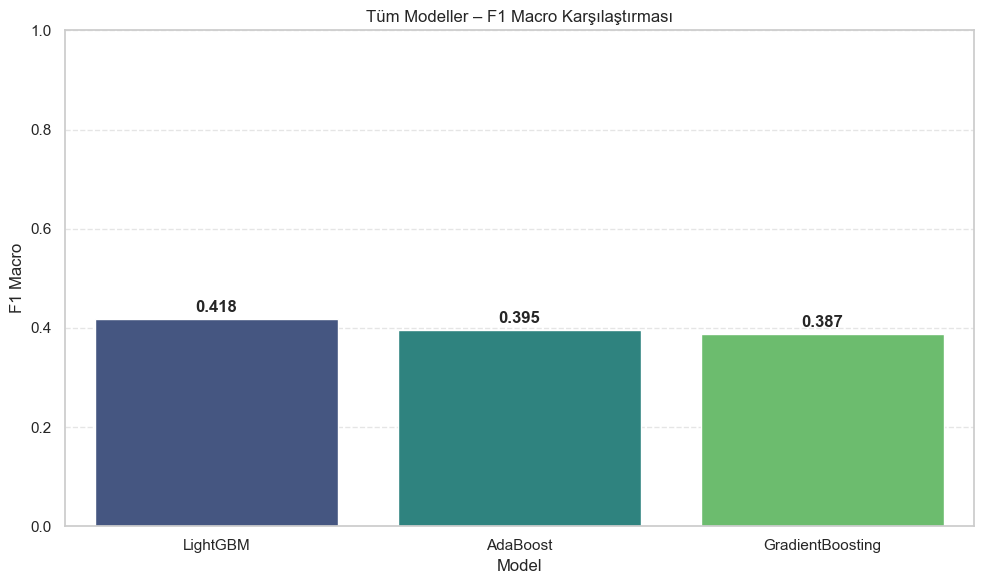

In [151]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Model',
    y='F1 Macro',
    data=results_df,
    palette='viridis'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontweight='bold')

plt.title("Tüm Modeller – F1 Macro Karşılaştırması")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
